In [2]:
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import matplotlib.colors
import ipdb
import copy
from scipy import sparse
import time
from sklearn.preprocessing import normalize
import memory_profiler as mprof

DEFINE LOCAL FUNCTIONS

In [3]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#####################################################################################
#####################################################################################

def plot_examples(trial):    
    box=trial['Teachers_box'];
    last_guess=trial['Learners_guess'][-1]['box'];
    
    fig=plt.figure;
        
    plt.plot([box[0],box[0],box[1],box[1],box[0]],[box[3],box[2],box[2],box[3],box[3]],'b');    
    if trial['won']:
        plt.plot([last_guess[0],last_guess[0],last_guess[1],last_guess[1],last_guess[0]],[last_guess[3],last_guess[2],last_guess[2],last_guess[3],last_guess[3]],'g');    
    else:
        plt.plot([last_guess[0],last_guess[0],last_guess[1],last_guess[1],last_guess[0]],[last_guess[3],last_guess[2],last_guess[2],last_guess[3],last_guess[3]],'r');    
    
    if any(np.array(last_guess) > 615):
        print(last_guess)
    
    examples=trial['Examples']
    for e in examples:
        if e['inside']=='true':
            plt.plot(e['x'],e['y'],'og')
        elif e['inside']=='false':
            plt.plot(e['x'],e['y'],'xk')
        else:
            print('warning: inside=',e['inside'])
            
    plt.ylim([0,616]);
    plt.xlim([0,616]);
    
    plt.grid()
    
    plt.show()
    return
    
#####################################################################################
#####################################################################################

def get_p_win(Trials):
    w=0
    for t in Trials:
        if t['won']:
            w+=1
    return w/len(Trials)

#####################################################################################
#####################################################################################

def distance_to_corners(rectangle,samples):
# samples is a list of tuples (x,y)    

    dist=[]
    corners=[(rectangle[0],rectangle[2]),(rectangle[0],rectangle[3]),(rectangle[1],rectangle[2]),(rectangle[1],rectangle[3])]
    
    
    for s in samples:
        d=[]
        for c in corners:
            d.append((s[0]-c[0])**2+(s[1]-c[1])**2)
        dist.append(np.sqrt(np.min(d)))
   
    if len(dist)==1:
        dist=dist[0]
                
    return dist



#####################################################################################
#####################################################################################


def individual_histogram(Pair,reference_box='teacher'): # as in the paper
    n_bins=3;
    canvas_size=616;
    inner_bins=np.zeros([n_bins,n_bins]); 
    outer_bins=np.zeros([n_bins+1,n_bins+1]);             
    n_trial=-1;
    
    if reference_box=='teacher':    
        for trial in Pair['Trials']:
                n_trial=n_trial+1;
                box=trial['Teachers_box'];
                width=box[1]-box[0];
                height=box[3]-box[2];                
                for sample in trial['Examples']:
                    if sample['inside']=='true': # CIRCLE
                        x=sample['x']-box[0];
                        y=sample['y']-box[2];
                        x_bin=np.int(np.floor(x/(width/n_bins)));
                        y_bin=np.int(np.floor(y/(height/n_bins)));
                        if(x_bin==3):
                            x_bin=2;
                        if(y_bin==3):
                            y_bin=2;                                
                        inner_bins[x_bin,y_bin ]=inner_bins[x_bin,y_bin]+1;     
                    else : # CROSS
                        if (sample['x']-box[0])<0: #left side
                            x=box[0]-sample['x'];
                            x_bin=np.int(np.floor(x/(box[0]/n_bins)))+1; # bins 1,2 or 3    
                        elif sample['x']>box[1]: #right side
                            x=sample['x']-box[1];
                            x_bin=np.int(np.floor(x/((canvas_size-box[1])/n_bins)))+1;
                        else: # above or below the box
                            x_bin=0;                                
                        if (sample['y']-box[2])<0: # above
                            y=box[2]-sample['y'];
                            y_bin=np.int(np.floor(y/(box[2]/n_bins)))+1;
                        elif sample['y']>box[3]: # below
                            y=sample['y']-box[3];
                            y_bin=np.int(np.floor(y/((canvas_size-box[3])/n_bins)))+1;
                        else:
                            y_bin=0;                                                                        
                        if x_bin>n_bins or y_bin>n_bins:
                            ipdb.set_trace()
                        outer_bins[x_bin,y_bin]=outer_bins[x_bin,y_bin]+1;  

        if np.any(np.isnan(outer_bins)):
            ipdb.set_trace()                    
        return inner_bins, outer_bins;

    else:
        
        
        for trial in Pair['Trials']:
                n_trial=n_trial+1;
                box=trial['Learners_guess'][-1]
                #box=trial['Teachers_box'];
                width=box[1]-box[0];
                height=box[3]-box[2];                
                for sample in trial['Examples']:
                    if sample['inside']=='true': # CIRCLE
                        x=sample['x']-box[0];
                        y=sample['y']-box[2];
                        x_bin=np.int(np.floor(x/(width/n_bins)));
                        y_bin=np.int(np.floor(y/(height/n_bins)));
                        if(x_bin==3):
                            x_bin=2;
                        if(y_bin==3):
                            y_bin=2;                                
                        inner_bins[x_bin,y_bin ]=inner_bins[x_bin,y_bin]+1;     
                    else : # CROSS
                        if (sample['x']-box[0])<0: #left side
                            x=box[0]-sample['x'];
                            x_bin=np.int(np.floor(x/(box[0]/n_bins)))+1; # bins 1,2 or 3    
                        elif sample['x']>box[1]: #right side
                            x=sample['x']-box[1];
                            x_bin=np.int(np.floor(x/((canvas_size-box[1])/n_bins)))+1;
                        else: # above or below the box
                            x_bin=0;                                
                        if (sample['y']-box[2])<0: # above
                            y=box[2]-sample['y'];
                            y_bin=np.int(np.floor(y/(box[2]/n_bins)))+1;
                        elif sample['y']>box[3]: # below
                            y=sample['y']-box[3];
                            y_bin=np.int(np.floor(y/((canvas_size-box[3])/n_bins)))+1;
                        else:
                            y_bin=0;                                                                        
                        if x_bin>n_bins or y_bin>n_bins:
                            ipdb.set_trace()
                        outer_bins[x_bin,y_bin]=outer_bins[x_bin,y_bin]+1;  

        if np.any(np.isnan(outer_bins)):
            ipdb.set_trace()                    
        return inner_bins, outer_bins;
        
    
#############################################################################
#############################################################################

def plot_trial(h,samples,circle,board_size,**kwargs):
    #plt.clf();
             

    probability_map=[];
    
    separate_in_out=False
    
    
    if kwargs is not None:
        if 'last_guess' in kwargs.keys():
            last_guess=kwargs['last_guess']
        if 'probability_map' in kwargs.keys():
            probability_map=kwargs['probability_map']
        if 'separate_in_out' in kwargs.keys():
            separate_in_out= kwargs['separate_in_out']
            
    if not separate_in_out:
        fig=plt.figure();
        if any(probability_map):
            probability_map=np.squeeze(probability_map)        
            in_plus_out=probability_map[0:board_size**2].reshape(board_size,board_size)+probability_map[board_size**2:2*board_size**2].reshape(board_size,board_size)        

            plt.pcolormesh(in_plus_out.transpose()) ;
            #plt.pcolormesh(probability_map[0:board_size**2].reshape(board_size,board_size)+probability_map[board_size**2:2*board_size**2].reshape(board_size,board_size))
            plt.colorbar() ;
            #plt.pcolor(probability_map['Examples_space'],probability_map['Probabilities'])        
        plt.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b') ;

        if 'last_guess' in kwargs.keys():
            plt.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');

        
        if any(samples):
            j=-1
            for e in samples:
                j+=1
                if circle[j]:
                    plt.plot(e[0]+0.5,e[1]+0.5,'ko');        
                else:
                    plt.plot(e[0]+0.5,e[1]+0.5,'kx') ;       

            e=samples[-1]
            if circle[-1]:
                plt.plot(e[0]+0.5,e[1]+0.5,'ko',ms=8);          
            else:
                plt.plot(e[0]+0.5,e[1]+0.5,'kx',ms=8) ;               

        plt.xlim([0,board_size]);
        plt.ylim([0,board_size]);
        plt.show() ;
        if kwargs is not None:
            if 'filename' in kwargs.keys():
                filename=kwargs['filename'];
                fig.savefig(filename);
                
    if separate_in_out:       

        probability_map=np.squeeze(probability_map)
        in_prob=probability_map[0:board_size**2].reshape(board_size,board_size)
        out_prob=probability_map[board_size**2:2*board_size**2].reshape(board_size,board_size)        
        in_plus_out=in_prob+out_prob                        
                
        f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5)) ;                       
        im=ax1.pcolormesh(in_prob.transpose()) ;
        f.colorbar(im, ax=ax1);
        
        if any(samples):        
            j=-1
            for e in samples:                    
                j+=1
                if circle[j]:
                    ax1.plot(e[0]+0.5,e[1]+0.5,'wo') ;       
                else:
                    ax1.plot(e[0]+0.5,e[1]+0.5,'wx')  ;      

            e=samples[-1]
            if circle[-1]:
                ax1.plot(e[0]+0.5,e[1]+0.5,'wo',ms=8)  ;      
            else:
                ax1.plot(e[0]+0.5,e[1]+0.5,'wx',ms=8)   ;              

        ax1.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b')   ;                 
        if 'last_guess' in kwargs.keys():
            ax1.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');

        im2=ax2.pcolormesh(out_prob.transpose());         
        f.colorbar(im2, ax=ax2);
        
        if any(samples):
        
            j=-1
            for e in samples:                    
                j+=1
                if circle[j]:
                    ax2.plot(e[0]+0.5,e[1]+0.5,'wo')        ;
                else:
                    ax2.plot(e[0]+0.5,e[1]+0.5,'wx')        ;

            e=samples[-1]
            if circle[-1]:
                ax2.plot(e[0]+0.5,e[1]+0.5,'wo',ms=8)        ;
            else:
                ax2.plot(e[0]+0.5,e[1]+0.5,'wx',ms=8)         ;        

        ax2.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b')  ;
        if 'last_guess' in kwargs.keys():
            ax2.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');        
        
        im3=ax3.pcolormesh(in_plus_out.transpose())  ;
        f.colorbar(im3, ax=ax3);
        
        if any(samples):        
            j=-1
            for e in samples:                    
                j+=1
                if circle[j]:
                    ax3.plot(e[0]+0.5,e[1]+0.5,'wo');
                else:
                    ax3.plot(e[0]+0.5,e[1]+0.5,'wx') ;       

            e=samples[-1]
            if circle[-1]:
                ax3.plot(e[0]+0.5,e[1]+0.5,'wo',ms=8) ;       
            else:
                ax3.plot(e[0]+0.5,e[1]+0.5,'wx',ms=8)  ;               

        ax3.plot([h[0],h[1],h[1],h[0],h[0]],[h[2],h[2],h[3],h[3],h[2]],'b');
        if 'last_guess' in kwargs.keys():
            ax3.plot([last_guess[0],last_guess[1],last_guess[1],last_guess[0],last_guess[0]],[last_guess[2],last_guess[2],last_guess[3],last_guess[3],last_guess[2]],'r');
        
        
        
        ax1.set_title('Circles distribution');
        ax2.set_title('Crosses distribution');
        ax3.set_title('Circles + Crosses');
                   
        if 'filename' in kwargs.keys():
            filename=kwargs['filename']
            f.savefig(filename)            
            
            
        plt.show();
    return                        

    
#####################################################################################
#####################################################################################

def plot_inner_histo(histo_inside):
    fig=plt.figure();      
    plt.pcolor(histo_inside,cmap='Greys')   
    plt.clim(0,0.35)
    plt.colorbar();    
    plt.plot([0,3,3,0,0],[0,0,3,3,0],'b')
    plt.xlim([-0.5,3.5])
    plt.ylim([-0.5,3.5])
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)    
    plt.show()
#    fig.savefig('circles_teachers_box_6.png')

    
#####################################################################################
#####################################################################################    
    
def plot_outer_histo(histo_outside):
    fig=plt.figure();
    plt.title('')
    plt.pcolor(histo_outside,cmap='Greys')
    plt.clim(0,0.4)
    plt.colorbar();
    plt.plot([0,1,1,0,0],[0,0,1,1,0],'b')
    plt.xlim([-0.03,4])
    plt.ylim([-0.01,4])    
    plt.tick_params(bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)
    plt.show()
#    fig.savefig('crosses_teachers_box_6.png')

#####################################################################################
#####################################################################################    
def distance_to_box(sample,rectangle):
                    
    if not (sample[0]<rectangle[0] or sample[0]>=rectangle[1] or sample[1]<rectangle[2] or sample[1]>=rectangle[3]): # sample inside the rectangle
        #print('Its a circle')                                
        return np.min([sample[0]-rectangle[0]+1 , rectangle[1]-sample[0] , sample[1]-rectangle[2]+1 , rectangle[3]-sample[1]])    
    elif sample[0]>=rectangle[0] and sample[0]<rectangle[1]:        
        if sample[1]>=rectangle[3]: # it is above
            #print('It is above')
            return sample[1]-rectangle[3]+1      
        elif sample[1]< rectangle[2]:
            #print('It is below')
            return rectangle[2]-sample[1]
    elif sample[1]>=rectangle[2] and sample[1]<rectangle[3]:
        #print('Its a cross right or left')
        if sample[0]<rectangle[0]: # it's on the left
            #print('It is on the left')
            return rectangle[0]-sample[0]
        elif sample[0]>=rectangle[1]: # it's on the right
            return sample[0]-rectangle[1] +1
    else:
        #print('Its a cross near the corners')
        if sample[0]<rectangle[0] and sample[1]>=rectangle[3] :
            return np.sqrt((sample[0]-rectangle[0])**2+ (sample[1]-rectangle[3]+1)**2)        
        elif sample[0]<rectangle[0] and sample[1]<rectangle[2]:
            return np.sqrt((sample[0]-rectangle[0])**2+ (sample[1]-rectangle[2])**2)    
        elif sample[0]>=rectangle[1] and sample[1]>=rectangle[3] :
            return np.sqrt((sample[0]-rectangle[1]+1)**2+ (sample[1]-rectangle[3]+1)**2)
        elif sample[0]>=rectangle[1] and sample[1]<rectangle[2]:
            return np.sqrt((sample[0]-rectangle[1]+1)**2+ (sample[1]-rectangle[2])**2)

    print('Something is wrong at computing within distance_to_box')
    return 
#####################################################################################
#####################################################################################    

def distance_to_corners(sample,rectangle):
    c1=(rectangle[0],rectangle[2])
    c2=(rectangle[1],rectangle[2])
    c3=(rectangle[0],rectangle[3])
    c4=(rectangle[1],rectangle[3])
    d=min((sample[0]-c1[0])**2+(sample[1]-c1[1])**2,\
          (sample[0]-c2[0])**2+(sample[1]-c2[1])**2,\
          (sample[0]-c3[0])**2+(sample[1]-c3[1])**2,\
          (sample[0]-c4[0])**2+(sample[1]-c4[1])**2 )
    
    box_size=np.sqrt((rectangle[0]-rectangle[1])**2+ (rectangle[2]-rectangle[3])**2)
    return np.sqrt(d)/box_size

#####################################################################################
#####################################################################################  


def define_hyp_and_examples_space(l,*min_size,**kwargs):
        
    smooth=False # smooth initial prior distribution giving higher probabilities to samples close to the boundaries of the hypothesis
    if kwargs is not None:
        if 'smooth' in kwargs.keys():     # pass the mothing argument as: smooth=['linear',alpha] for 1-alpha*distance or ['exp',lambda] for exp[-lambda*distance]
            smooth=True
            type_of_smooth=kwargs['smooth'][0]
            smooth_param=kwargs['smooth'][1]
                                                
    if min_size:
        min_size=min_size[0]        
    else:
        min_size=1            
        
    #l=12; # size of the board
    X_left=range(l-min_size+1); 
    Y_bott=range(l-min_size+1); # y: # SUMAR 1 !!!!!!!!!!!!!!!!!
    x_max=l; # max value of x_right
    y_max=l; # max value of y_top
    H_space=[];
    for xl in X_left:
        for yb in Y_bott:
            for xr in range(xl+min_size,x_max+1):
                for yt in range(yb+min_size,y_max+1):                                
                    H_space.append((xl,xr,yb,yt))
    
    Examples=[];
    for i in range(l):
        for j in range(l):
            Examples.append((i,j)); # CIRCLES: elements 0...(l**2)-1

    if not smooth:
        COO_I=[]
        COO_J=[]    
        M=sparse.coo_matrix((2*(l**2),len(H_space)) ,dtype=bool)        
        c=0
        for i in range(0,l**2): # if the sample is consistent with the hypothesis M(sample,hyp)=1        
            #print((l**2)-i)
            e1=Examples[i];                                
            for k in range(0,len(H_space)):
                h=H_space[k];
                if not (e1[0]<h[0] or e1[0]>=h[1] or e1[1]<h[2] or e1[1]>=h[3]): # CIRCLES INSIDE
                    COO_I.append(i)
                    COO_J.append(k)
                else:
                    COO_I.append(i+(l**2))
                    COO_J.append(k)
                if len(COO_I)==50000000:
                    c+=1
                    print('ADDING MATRICES',c)
                    M=M+sparse.coo_matrix((np.ones(len(COO_I)),(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=bool)        
                    print('DONE')
                    COO_I=[]
                    COO_J=[]
        if any(COO_I):
            M=M+sparse.coo_matrix((np.ones(len(COO_I)),(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=bool)
            
    elif type_of_smooth=='exp':
        COO_I=[]
        COO_J=[]    
        values=[]
        M=sparse.coo_matrix((2*(l**2),len(H_space)) ,dtype=float)           
        c=0
        for i in range(0,l**2): # if the sample is consistent with the hypothesis M(sample,hyp)=1        
            #print((l**2)-i)
            e1=Examples[i];                                
            for k in range(0,len(H_space)):
                h=H_space[k];                                                
                distance_to_hyp=distance_to_box(e1,h)                                                                                                  
                
                values.append(np.exp(-distance_to_hyp * smooth_param))
                if e1==(10,12) and h==(7,12,7,12):
                    print('The distance is:',distance_to_hyp)
                    print('The value is:',values[-1])
                    
                    
             #   print('Distance:',distance_to_hyp, 'value:',values[-1])
                if not (e1[0]<h[0] or e1[0]>=h[1] or e1[1]<h[2] or e1[1]>=h[3]): # CIRCLES INSIDE                                        
                    COO_I.append(i)
                    COO_J.append(k)
                else:
                    COO_I.append(i+(l**2))
                    COO_J.append(k)
                if len(COO_I)==50000000:
                    c+=1
                    print('ADDING MATRICES',c)
                    M=M+sparse.coo_matrix((values,(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=float)        
                    print('DONE')
                    values=[]
                    COO_I=[]
                    COO_J=[]
        if any(COO_I):
            M=M+sparse.coo_matrix((values,(COO_I,COO_J)), shape=(2*(l**2),len(H_space)) ,dtype=float)        
        
                
    '''
    M=sparse.coo_matrix((np.ones(len(COO_I)),(COO_I,COO_J)), shape=(l**2,len(H_space)) ,dtype=bool)        
    idx=(M==0).nonzero()
    M1=sparse.coo_matrix((np.ones(len(idx[0])),idx),shape=(l**2,len(H_space)) ,dtype=bool) # COMPLEMENT OF M: ROWS ARE CROSSES NOW, AND THE 1's IN M BECOME 0's AND VICEVERSA
    M2=sparse.vstack([M,M1],dtype=bool)# CIRCLES AND CROSSES STACKED
    '''
    
    '''
    for i in range(l**2,2*(l**2)):
        #print(2*(l**2)-i)
        e1=Examples[i];              
        ne+=1;
        for k in range(0,len(H_space)):
            h=H_space[k];
            if (e1[0]<h[0] or e1[0]>=h[1] or e1[1]<h[2] or e1[1]>=h[3]): # CROSSES OUTSIDE
                M[ne,k]=1;                                                                       
    '''          
        
    return M,Examples,H_space
            
#############################################################################
#############################################################################

def coord_to_idx(cell_size,*coords):
    idx=[]
    for c in coords:
        idx.append(int(np.round(c/cell_size)))
    return idx
        
#############################################################################
#############################################################################.

def get_TL_sparse(M):
    
    print('Creating TL')
    t0=time.time()
    TL=M.copy()
    TL=TL.tocsc()        
    TL=TL.astype(float)
    
    t1=time.time()
    print('Done in:',t1-t0,' sec')
    print('Memory: ',mprof.memory_usage())
    
    t00=time.time()        
    
    last_relative_distance=1
    for k in range(0,1000):
        
        #L0=L[:]
        #T0=T[:]
        #t0=time.time()

        t0=time.time()
        
        TL0=TL.data;        
        
        TL=normalize(TL,norm='l1',axis=1)                                       
        TL=normalize(TL,norm='l1',axis=0)
        
        relative_distance=np.max(np.abs((TL.data-TL0)/TL0))
        
        marginal_improvement=(last_relative_distance-relative_distance)/last_relative_distance
        
        t1=time.time()
        print('Iteration:',k,' Time:',t1-t0,' Distance:',relative_distance,' marginal-improvement:',marginal_improvement )        
        
        last_relative_distance=relative_distance
        
        if (relative_distance < 0.001):                
            converged=True
            break
            
        elif (k>20 and marginal_improvement<0.01):
            converged=False
            break
                                                             
    t11=time.time()
    print('Total SK iteration time:',t11-t00)
    
    return TL, relative_distance, converged


#############################################################################
#############################################################################


def correct_discretized_samples(e,sample,true_hyp):    
    if e['inside']=='true' and (sample[0]<true_hyp[0] or sample[0]>=true_hyp[1] or sample[1]<true_hyp[2] or sample[1]>=true_hyp[3]):
        #print('-------------------------')
        #print('Inside:',e['inside'])
        #print('sample:',sample)
        #print('hyp:',true_hyp)
        
        if sample[0]<true_hyp[0]:
            sample[0]=true_hyp[0]
        if sample[0]>=true_hyp[1]:
            sample[0]=true_hyp[1]-1
        if sample[1]<true_hyp[2]:
            sample[1]=true_hyp[2]
        if sample[1]>=true_hyp[3]:
            sample[1]=true_hyp[3]-1
            
        #print('new sample:',sample)
        
    elif e['inside']=='false' and not(sample[0]<true_hyp[0] or sample[0]>=true_hyp[1] or sample[1]<true_hyp[2] or sample[1]>=true_hyp[3]):
        #print('-------------------------')
        #print('Inside:',e['inside'])
        #print('sample:',sample)
        #print('hyp:',true_hyp)                
        j=np.argmin(np.abs([sample[0]-true_hyp[0],sample[0]-true_hyp[1],sample[1]-true_hyp[2] , sample[1]-true_hyp[3]]))
        if j==0:
            sample[0]=true_hyp[0]-1
        elif j==1:
            sample[0]=true_hyp[1]
        elif j==2:
            sample[1]=true_hyp[2]-1
        elif j==3:
            sample[1]=true_hyp[3]
    
        #print('new sample:',sample)
        
    return sample
            


    
#############################################################################
#############################################################################            
    
def discretize_data(Data):

    canvas_size=616
    grid_size=30
    cell_size=canvas_size/grid_size

    ncorr=0
    tot=0

    Data_discretized=copy.deepcopy(Data)

    Repeated_examples=0

    Repeated_boxes=0

    n_trials=0

    move_Id=-1
    for d in Data_discretized:    

        for t in d['Trials']:
            n_trials+=1

            true_hyp=coord_to_idx(cell_size,*t['Teachers_box'])           
            t['Teachers_box']=true_hyp

            boxes=[]
            there_are_repeated_boxes=False

            for guess in t['Learners_guess']:
                box=coord_to_idx(cell_size,*guess['box'])
                guess['box']=box

                if box in boxes:
                    there_are_repeated_boxes=True
                boxes.append(box)

            if there_are_repeated_boxes:
                Repeated_boxes+=1


            examples=[]
            there_are_repeated_examples=False

            for e in t['Examples']:            

                sample=coord_to_idx(cell_size,*[e['x'],e['y']])        
                orig_sample=copy.deepcopy(sample)
                new_sample=correct_discretized_samples(e,sample,true_hyp)  

                e['x']=new_sample[0]
                e['y']=new_sample[1]

                move_Id+=1
                e['move_Id']=move_Id

                if new_sample in examples:
                    there_are_repeated_examples=True                                    
                examples.append(new_sample)

            if there_are_repeated_examples:
                Repeated_examples+=1
                
    return Data_discretized
            
                                                                                    
#############################################################################
#############################################################################

def correct_discretized_boxes(box,examples):
        
    new_box=copy.deepcopy(box)
        
    for e in examples:
        if e['inside']=='true' and (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            if e['x']<new_box[0]:
                new_box[0]=e['x']
            if e['x']>=new_box[1]:
                new_box[1]=e['x']+1
            if e['y']<new_box[2]:
                new_box[2]=e['y']
            if e['y']>=new_box[3]:
                new_box[3]=e['y']+1
        
        if e['inside']=='false' and not (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            m=np.argmin( np.abs([e['x']-new_box[0] , e['x']-new_box[1] , e['y']-new_box[2] , e['y']-new_box[3]  ] ))
            if m==0:
                new_box[0]=e['x']+1
            elif m==1:
                new_box[1]=e['x']
            elif m==2:
                new_box[2]=e['y']+1
            elif m==3:
                new_box[3]=e['y']
            '''
            print('CORRECTING BOX')
            print('m:',m)
            print('box:',box)
            print('Example:',(e['x'],e['y']))
            print('new_box:',new_box)
            '''    
                
                
    
    # check if it worked
    worked=True
    for e in examples:
        if e['inside']=='true' and (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            worked=False
        if e['inside']=='false' and not (e['x']<new_box[0] or e['x']>=new_box[1] or e['y']<new_box[2] or e['y']>=new_box[3]):
            worked=False

            
    if not worked:
        new_box=box
        
    return new_box, worked

#############################################################################
#############################################################################
    
def cdf(data):
    n = len(data)
    x = np.sort(data) # sort your data
    x=x[::-1]
    y = np.arange(1, n + 1) / n # calculate cumulative probability
    return x, y

#############################################################################
#############################################################################

def cdf_fixing_x_axis(data,axis):
    
    y=[]
    data=np.array(data)
    
    for value in axis:
        y.append(np.sum(data>=value))
    y=np.array(y)/len(data)

    return y

#############################################################################
#############################################################################
def check_if_inside(sample,box):

    if (sample[0]<box[0] or sample[0]>=box[1] or sample[1]<box[2] or sample[1]>=box[3]):
        return False
    else:
        return True
    
    
    
    
    

Load Raw data

In [4]:
Data=load_obj('../Data/Data_new_Id/Data');
#Data=load_obj('../../Data/Data');

for d in Data: # There is one trial with coordinates out of canvas_size. remove it.
    for t in d['Trials']:
        flag=False ;
        for e in t['Examples']:
            if e['x']>616 or e['y']>616:
                print(d['Teachers_Id'],d['Learners_Id'])
                print(e['x'],e['y'])
                flag=True
        if flag:
            d['Trials'].remove(t)
            
            

12 20
681.0 475.0


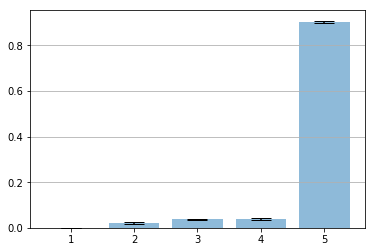

"\nfor d in Data:\n    n_s=0\n    for t in d['Trials']:\n        n_s+=len(t['Examples'])        \n    n_s=n_s/len(d['Trials'])\n    \n    if d['Level']==6:\n        n_samp_6.append(n_s)\n    elif d['Level']==4:\n        n_samp_4.append(n_s)\n    elif d['Level']==2:\n        n_samp_2.append(n_s)\n    \nplt.hist(n_samp_2)\n#plt.xlim([0,5])\nplt.show()\n\nplt.hist(n_samp_4)\n#plt.xlim([0,5])\nplt.show()\n\nplt.hist(n_samp_6)\n#plt.xlim([0,5])\nplt.show()  \n"

In [268]:
# NUMBER OF SAMPLES PER TRIAL


level=2
n=n2

proportions=np.zeros([n,5])


i=-1;
for d in Data:
    n_s=0
    samples=np.zeros(5)
    if d['Level']==level:
        i+=1
        for t in d['Trials']:
            n_s+=len(t['Examples'])
            samples[len(t['Examples'])-1]+=1
        proportions[i,:]=samples/len(d['Trials'])
    
x=[1,2,3,4,5]

fig, ax = plt.subplots()
ax.bar(x,  np.mean(proportions,axis=0), yerr=np.std(proportions,axis=0)/n , align='center', alpha=0.5, ecolor='black', capsize=10)

#ax.set_xlabel('Number of examples',fontsize=15)
#ax.set_ylabel('Fraction of trials',fontsize=15)
ax.set_xticks(x)

#ax.set_xticklabels(materials)
#ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)
plt.show()

fig.savefig('Number_of_samples_'+str(level)+'.png')



'''
for d in Data:
    n_s=0
    for t in d['Trials']:
        n_s+=len(t['Examples'])        
    n_s=n_s/len(d['Trials'])
    
    if d['Level']==6:
        n_samp_6.append(n_s)
    elif d['Level']==4:
        n_samp_4.append(n_s)
    elif d['Level']==2:
        n_samp_2.append(n_s)
    
plt.hist(n_samp_2)
#plt.xlim([0,5])
plt.show()

plt.hist(n_samp_4)
#plt.xlim([0,5])
plt.show()

plt.hist(n_samp_6)
#plt.xlim([0,5])
plt.show()  
'''

In [263]:
proportions

array([[ 0.        ,  0.        ,  0.125     ,  0.        ,  0.875     ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.25      ,  0.        ,  0.        ,  0.75      ],
       [ 0.        ,  0.        ,  0.        ,  0.28571429,  0.71428571],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.11111111,  0.        ,  0.88888889],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.11111111,  0.11111111,  0.77777778],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.11111111,  0.        ,  0.88888889],
       [ 0.        ,  0.        ,  0.        ,  0.16666667,  0.83333333],
       [ 0.        ,  0.        ,  0.2       ,  0.        ,  0.8       ],
       [ 0.        ,  0.        ,  0. 

array([ 0.,  0.,  0.,  0.,  0.])

In [247]:



46

46

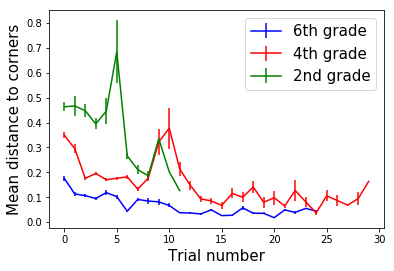

"\nn_samples=[[],[],[]]    \nfor d in Data:        \n    for t in d['Trials']:\n        it+=1\n        true_box=t['Teachers_box']\n        if d['Level']==2:\n            n_samples[0].append(len(t['Examples']))\n        elif d['Level']==4:\n            n_samples[1].append(len(t['Examples']))\n        elif d['Level']==6:\n            n_samples[2].append(len(t['Examples']))\n            \nnp.mean(n_samples[0])            \n"

In [216]:
# DISTANCE SAMPLES TO CORNERS VS TRIAL NUMBER

level=[2,4,6]

cmap = plt.cm.gray_r

n6=0
n4=0
n2=0
max_trial_6=0
max_trial_4=0
max_trial_2=0

min_trial_6=99
min_trial_4=99
min_trial_2=99
for d in Data:            
    if d['Level']==6:
        n6+=1
        max_trial_6=max(max_trial_6,len(d['Trials']))
        min_trial_6=min(min_trial_6,len(d['Trials']))
    elif d['Level']==4:
        n4+=1
        max_trial_4=max(max_trial_4,len(d['Trials']))
        min_trial_4=min(min_trial_4,len(d['Trials']))
    elif d['Level']==2:
        n2+=1
        max_trial_2=max(max_trial_2,len(d['Trials']))
        min_trial_2=min(min_trial_2,len(d['Trials']))

f1=plt.figure()

All_distances_vs_trial_6=np.zeros([n6,max_trial_6])
All_distances_vs_trial_4=np.zeros([n4,max_trial_4])
All_distances_vs_trial_2=np.zeros([n2,max_trial_2])

j6=-1
j4=-1
j2=-1

data_framed={'Id':[],'Level':[],'Trial_Number':[],'DV':[]}
data_framed_dummy={'Id':[],'Level':[],'Trial_0':[],'Trial_1':[],'Trial_2':[],'Trial_3':[],'Trial_4':[],'Trial_5':[],'Trial_6':[],'Trial_7':[],'Trial_8':[],'Trial_9':[],\
                                'Trial_10':[],'Trial_11':[],'Trial_12':[],'Trial_13':[],'Trial_14':[],'Trial_15':[],'Trial_16':[],'Trial_17':[],'Trial_18':[],'Trial_19':[],\
                                'Trial_20':[],'Trial_21':[],'Trial_22':[],'Trial_23':[],'Trial_24':[],'Trial_25':[],'Trial_26':[],'Trial_27':[],'Trial_28':[],'Trial_29':[],'DV':[]}

for d in Data:        
    if d['Level'] in level:                
        Distances_vs_trial=[]
        it=-1
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=len(d['Trials']))
        for t in d['Trials']:
            it+=1
            true_box=t['Teachers_box']
            distance_vs_n_sample=[]
            for example in t['Examples']:
                sample=(example['x'],example['y'])
                dist=distance_to_corners(sample,true_box)                                             
                distance_vs_n_sample.append(dist)  
                
            Distances_vs_trial.append(np.mean(distance_vs_n_sample))    
            
            if not (d['Level']==4 and it>=27):
                data_framed['Id'].append(d['Teachers_Id'])
                data_framed['Level'].append(d['Level'])
                data_framed['Trial_Number'].append(it)
                data_framed['DV'].append(np.mean(distance_vs_n_sample))

                
            
            '''
            plt.figure(f2.number)   
            plt.plot(distance_vs_n_sample,'-o',color=cmap(norm(it)))            
            plt.xlabel('Nr of samples')
            plt.ylabel('Guess Error')         
        
            '''
        if d['Level']==6:
            j6+=1
            All_distances_vs_trial_6[j6,:len(Distances_vs_trial)]=Distances_vs_trial
        elif d['Level']==4:
            j4+=1
            All_distances_vs_trial_4[j4,:len(Distances_vs_trial)]=Distances_vs_trial
        elif d['Level']==2:
            j2+=1
            All_distances_vs_trial_2[j2,:len(Distances_vs_trial)]=Distances_vs_trial
                                    
        #plt.show()
        '''
        plt.figure(f1.number);
        #plt.clf()
        plt.plot(Distances_vs_trial,'-ro')
        plt.xlabel('Trial')
        plt.ylabel('Sum of errors')
        plt.show()
        '''

#All_distances_vs_trial_2=All_distances_vs_trial_2[:,:-3]

plt.clf()
fig=plt.figure()

mn=[]
err=[]
for j in range(All_distances_vs_trial_6.shape[1]):
    sample=All_distances_vs_trial_6[All_distances_vs_trial_6[:,j]>0,j]
    n_s=np.sum(All_distances_vs_trial_6[:,j]>0)
    mn.append(np.mean(sample))
    err.append(np.std(sample)/n_s)
    
plt.errorbar(range(len(mn)),mn,err,color='b')

mn=[]
err=[]
for j in range(All_distances_vs_trial_4.shape[1]):
    sample=All_distances_vs_trial_4[All_distances_vs_trial_4[:,j]>0,j]
    n_s=np.sum(All_distances_vs_trial_4[:,j]>0)
    mn.append(np.mean(sample))
    err.append(np.std(sample)/n_s)
    
plt.errorbar(range(len(mn)),mn,err,color='r')

mn=[]
err=[]
for j in range(All_distances_vs_trial_2.shape[1]):
    sample=All_distances_vs_trial_2[All_distances_vs_trial_2[:,j]>0,j]
    n_s=np.sum(All_distances_vs_trial_2[:,j]>0)
    mn.append(np.mean(sample))
    err.append(np.std(sample)/n_s)
    
plt.errorbar(range(len(mn)),mn,err,color='g')
plt.legend(['6th grade','4th grade','2nd grade'],fontsize='15')

'''
I2=1507.4957
I4=I2-550.1874
I6=I2-847.3417
slope_2=-73.9588
slope_4=slope_2+45.5169
slope_6=slope_2+ 54.4068 

x_aux=np.array(range(10))
y_2=x_aux*slope_2+I2
plt.plot(x_aux,y_2,'--g')

x_aux=np.array(range(30))
y_4=x_aux*slope_4+I4
plt.plot(x_aux,y_4,'--r')

x_aux=np.array(range(25))
y_6=x_aux*slope_6+I6
plt.plot(x_aux,y_6,'--b')
'''

plt.xlabel('Trial number',fontsize=15)
plt.ylabel("Mean distance to corners",fontsize=15)

plt.show()    

fig.savefig('Normalized_mean_distance_to_corner_vs_trial.png',dpi=300)

###############################################        
'''
n_samples=[[],[],[]]    
for d in Data:        
    for t in d['Trials']:
        it+=1
        true_box=t['Teachers_box']
        if d['Level']==2:
            n_samples[0].append(len(t['Examples']))
        elif d['Level']==4:
            n_samples[1].append(len(t['Examples']))
        elif d['Level']==6:
            n_samples[2].append(len(t['Examples']))
            
np.mean(n_samples[0])            
'''                        

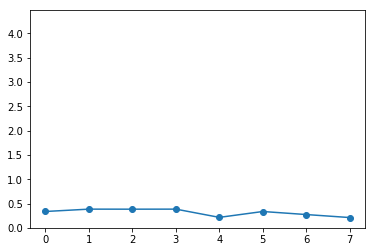

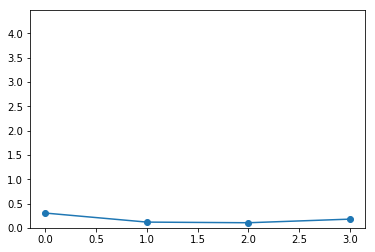

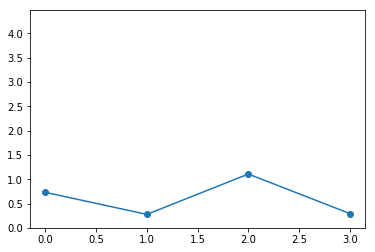

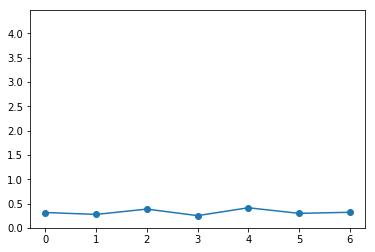

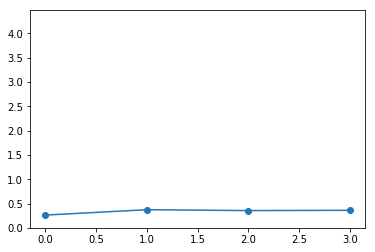

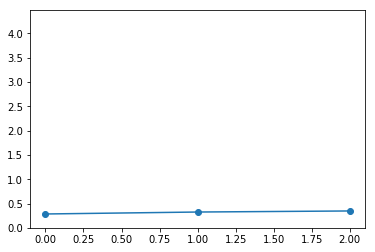

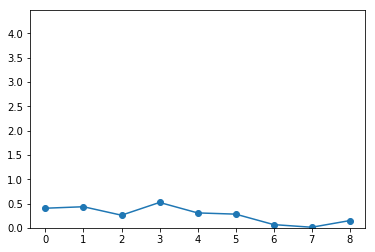

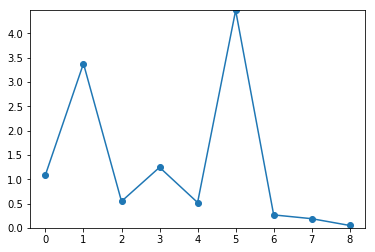

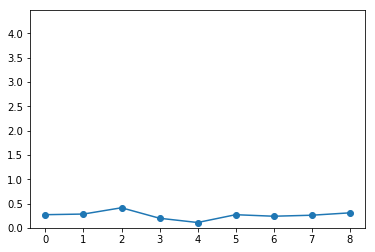

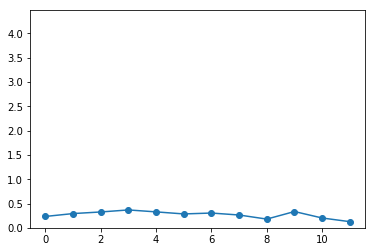

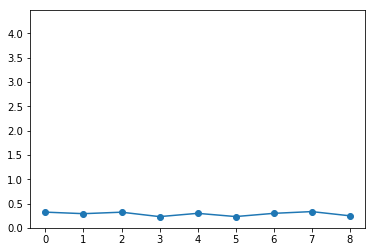

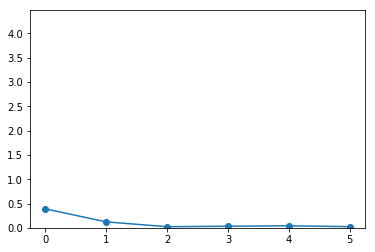

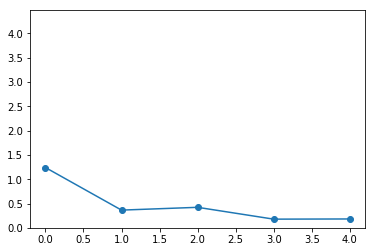

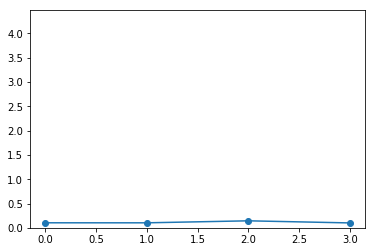

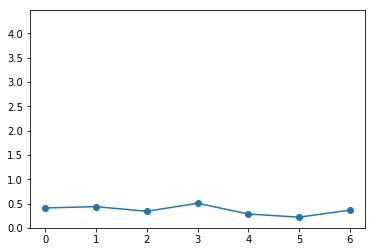

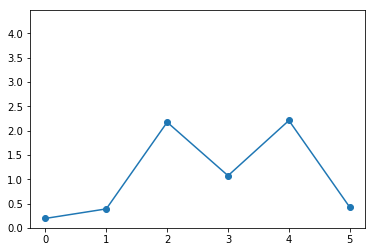

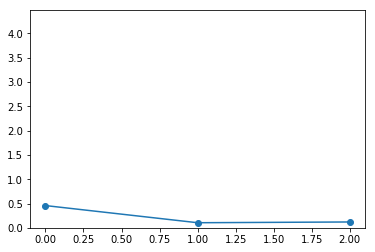

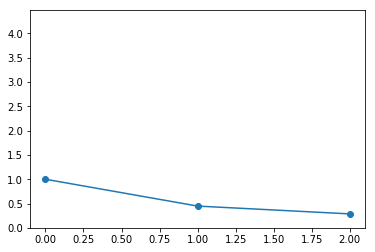

In [215]:
Aux=All_distances_vs_trial_2

for idx_s in range(Aux.shape[0]):
    plt.plot(Aux[idx_s,Aux[idx_s,:]>0],'-o')
    plt.ylim([0,np.max(Aux)])
    plt.show()

In [224]:
n6*2

30

In [211]:
np.min(All_distances_vs_trial_4)

0.0

In [154]:
rectangle=true_box
c1=(rectangle[0],rectangle[2])
c2=(rectangle[1],rectangle[2])
c3=(rectangle[0],rectangle[3])
c4=(rectangle[1],rectangle[3])
d=min((sample[0]-c1[0])**2+(sample[1]-c1[1])**2,\
      (sample[0]-c2[0])**2+(sample[1]-c2[1])**2,\
      (sample[0]-c3[0])**2+(sample[1]-c3[1])**2,\
      (sample[0]-c4[0])**2+(sample[1]-c4[1])**2 )  

TypeError: unsupported operand type(s) for -: 'float' and 'list'

In [170]:
c4

([67, 152, 229, 416], 416)

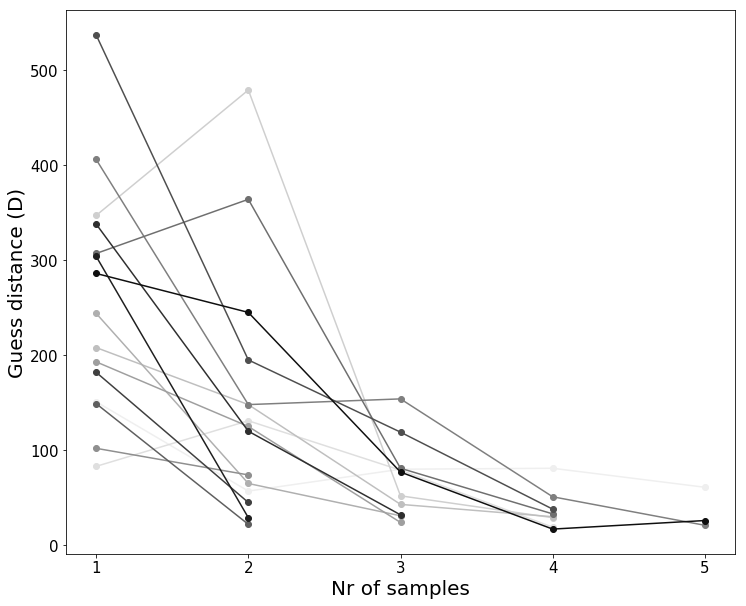

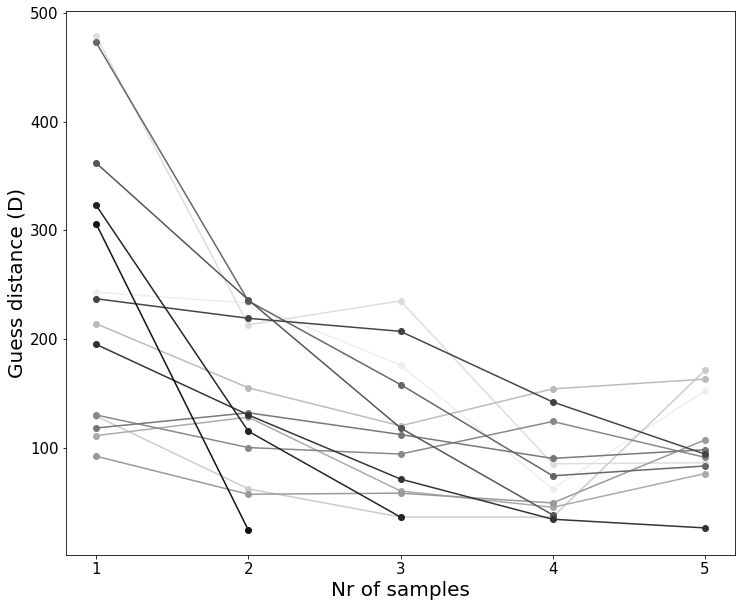

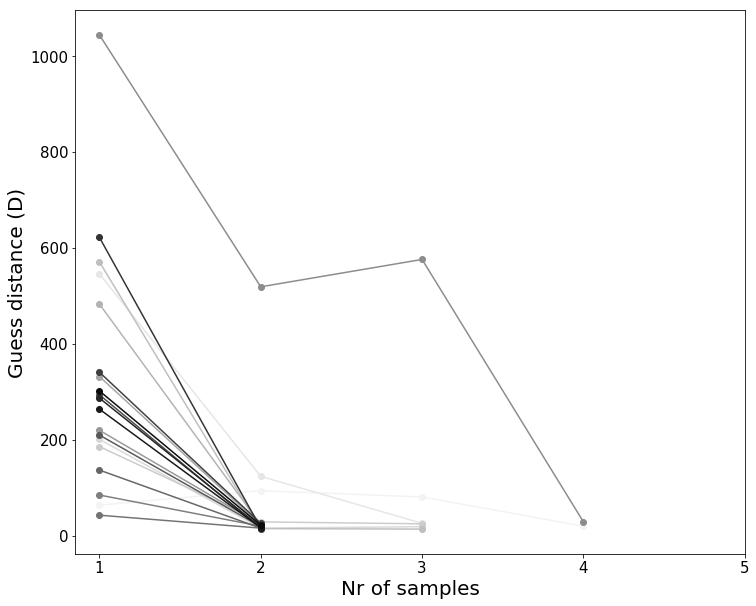

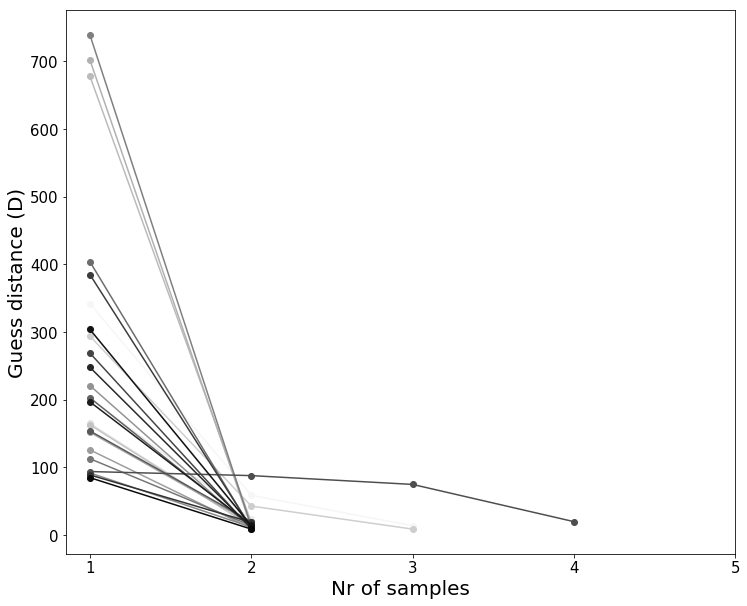

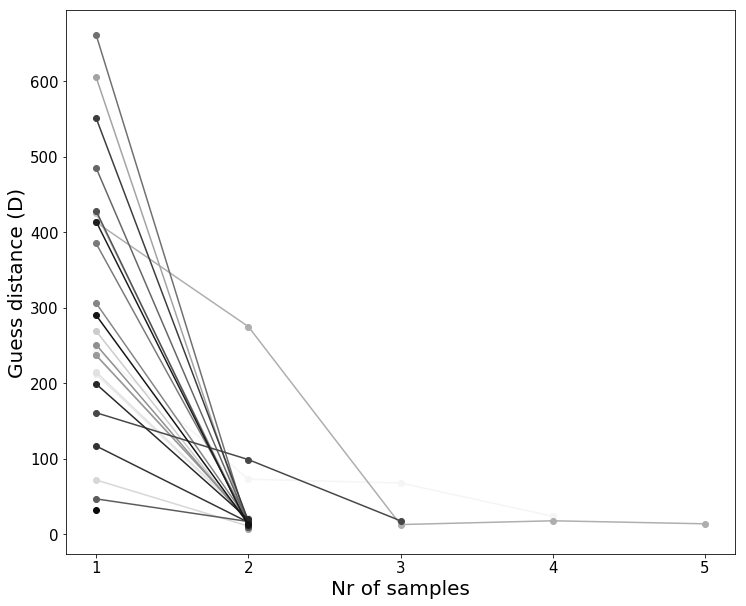

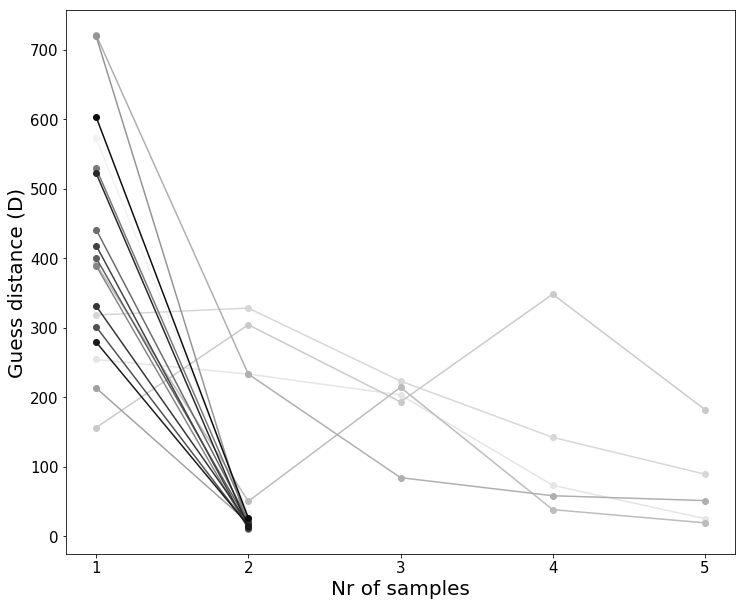

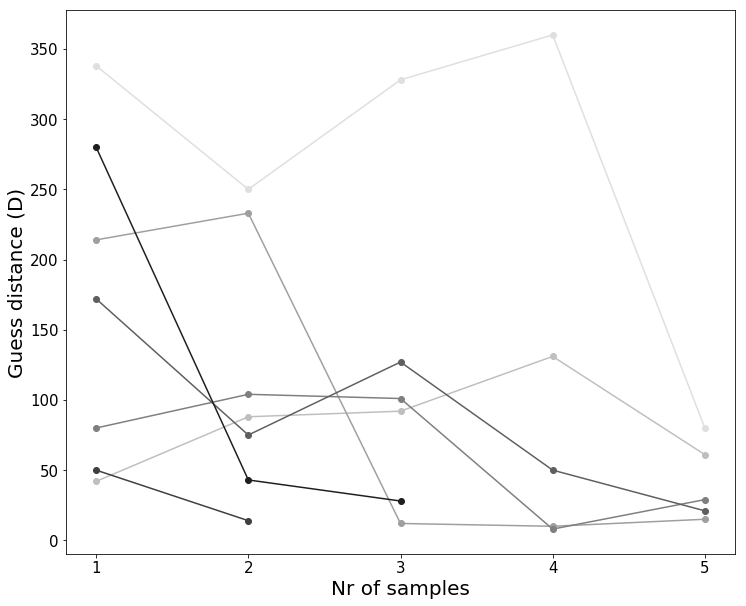

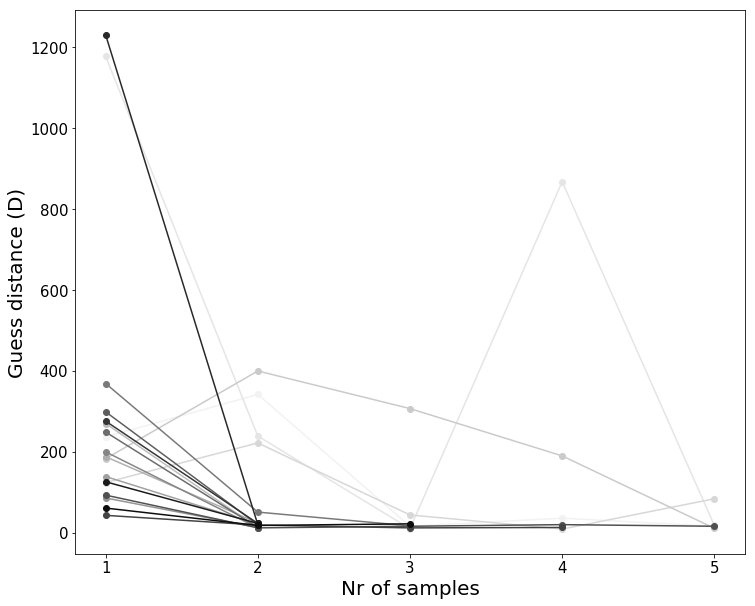

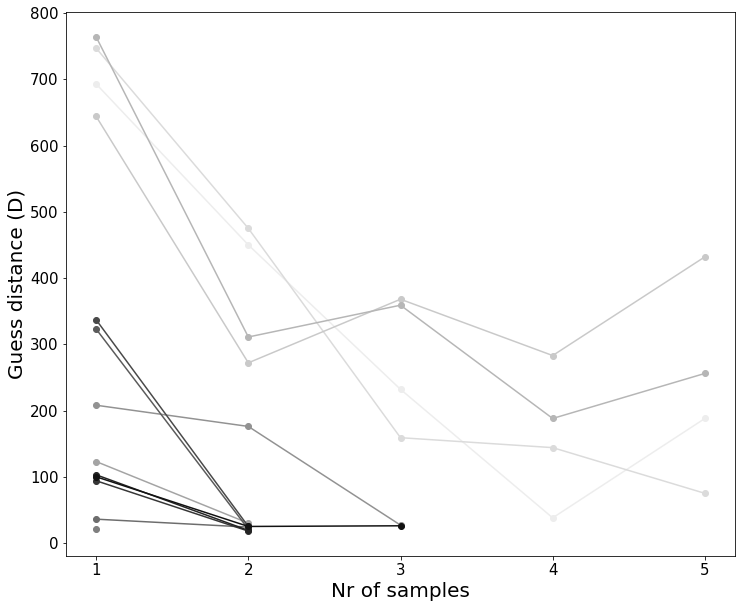

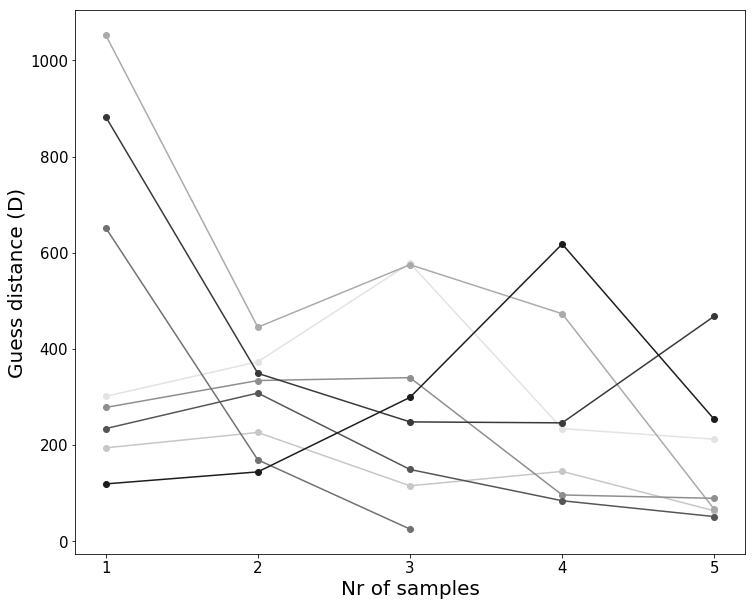

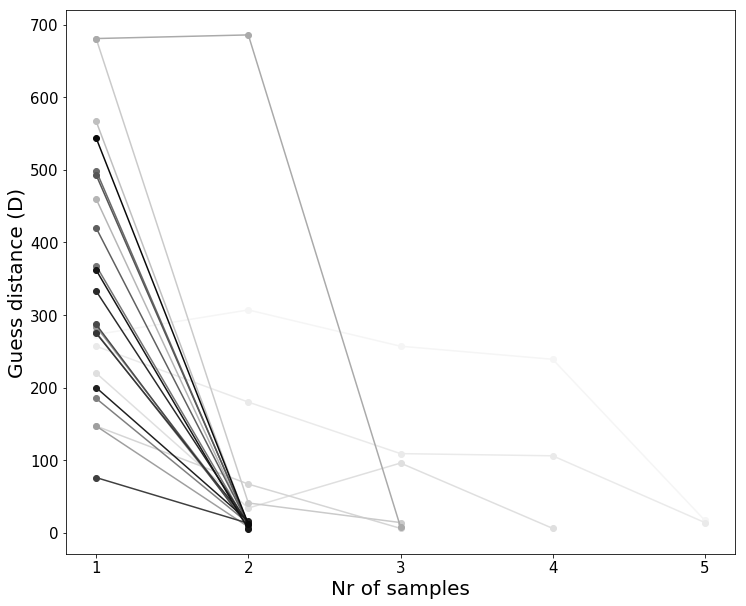

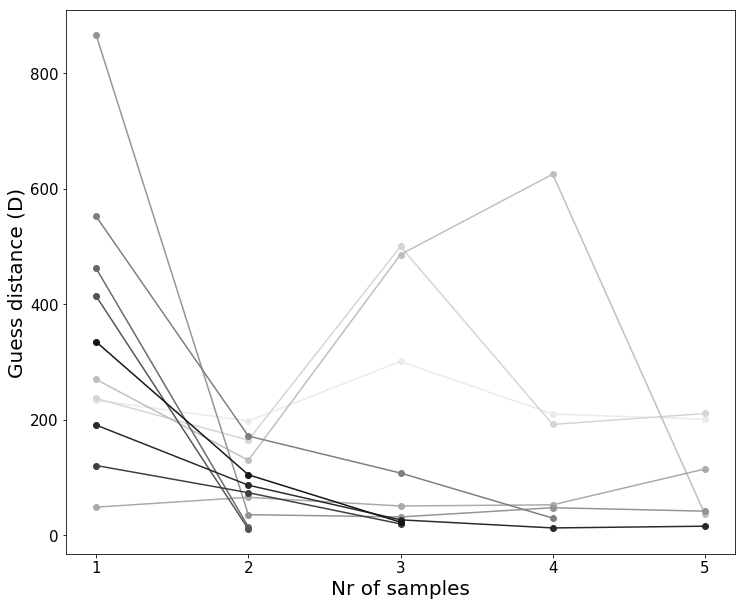

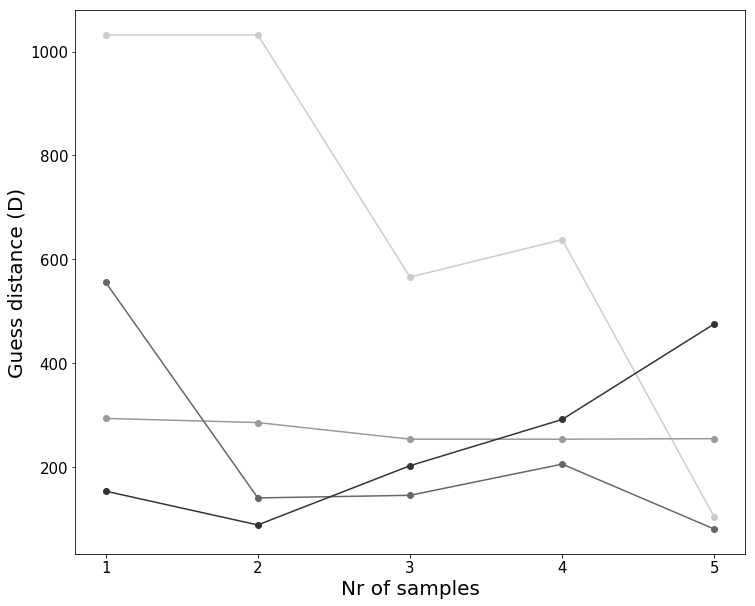

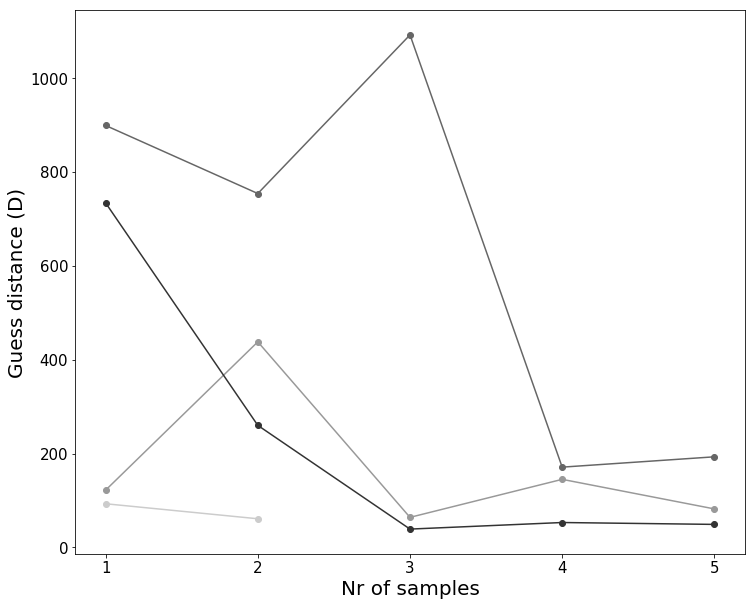

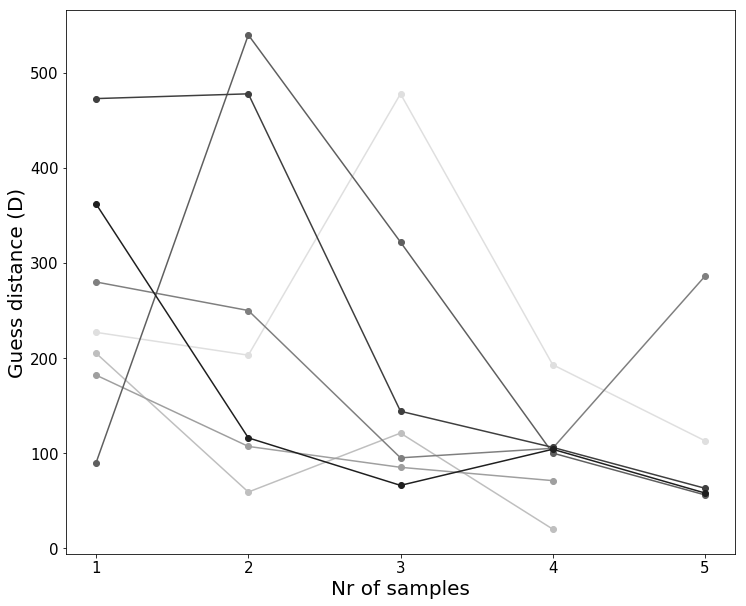

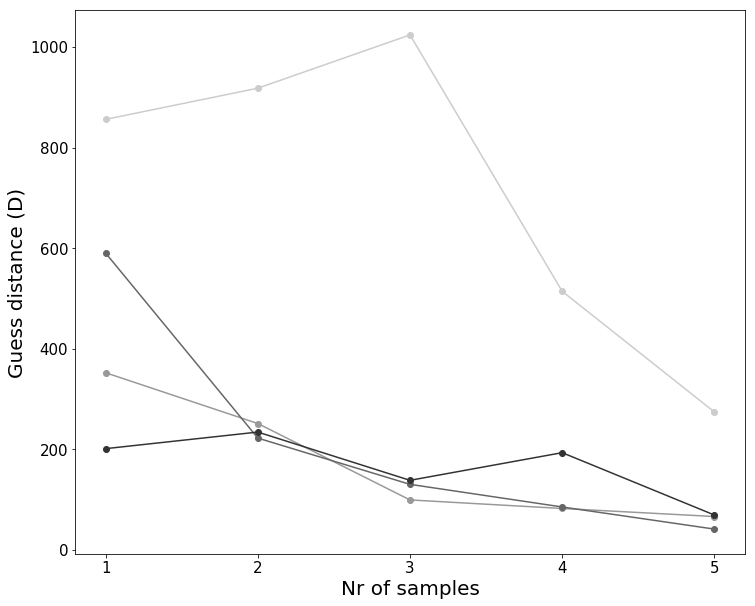

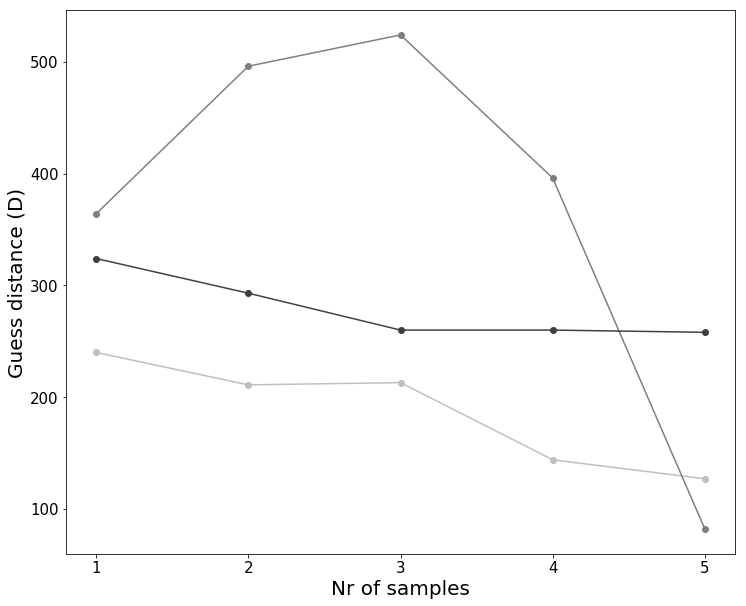

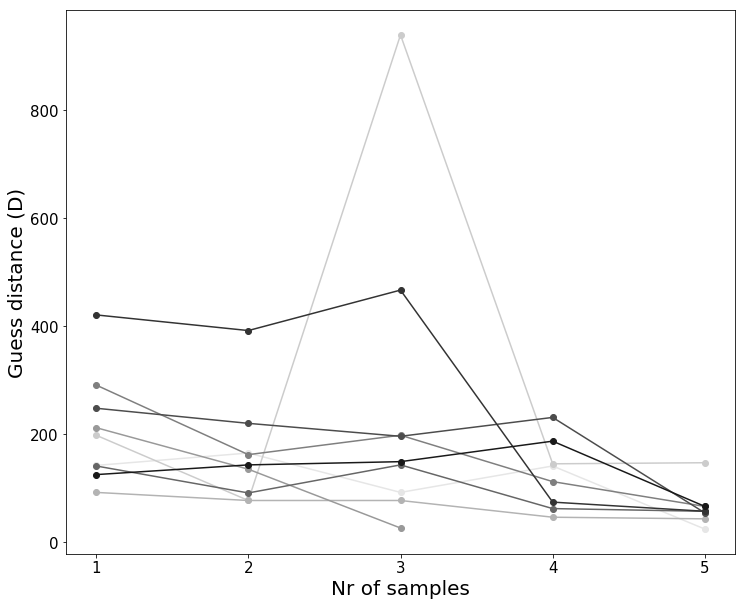

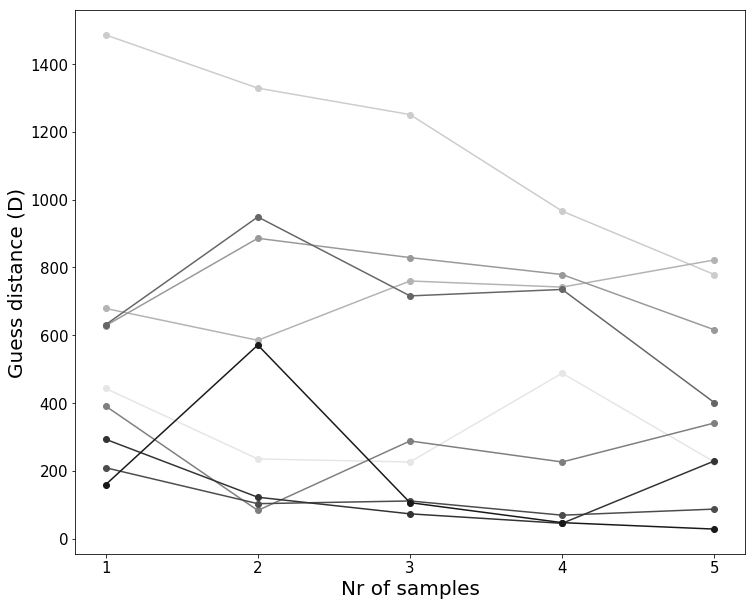

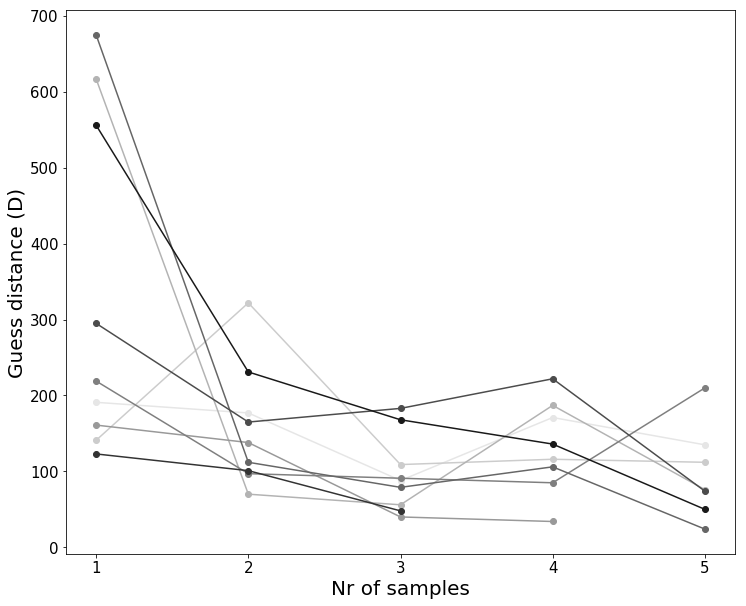

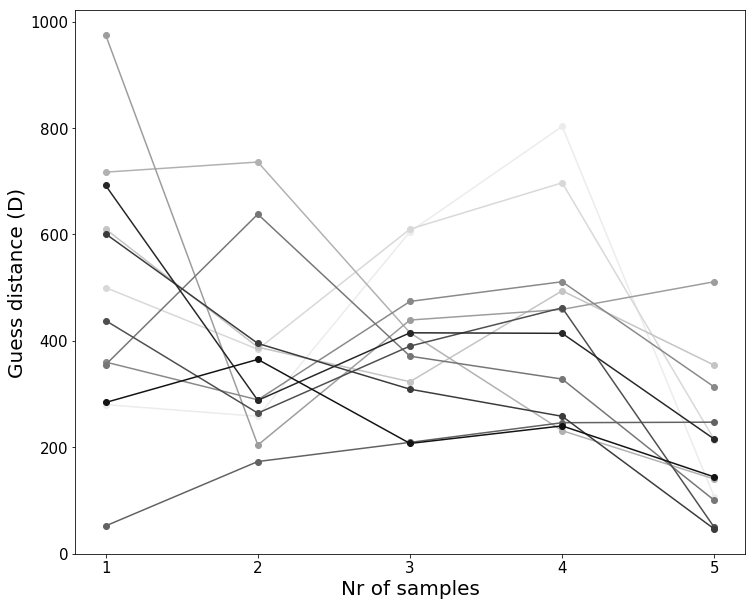

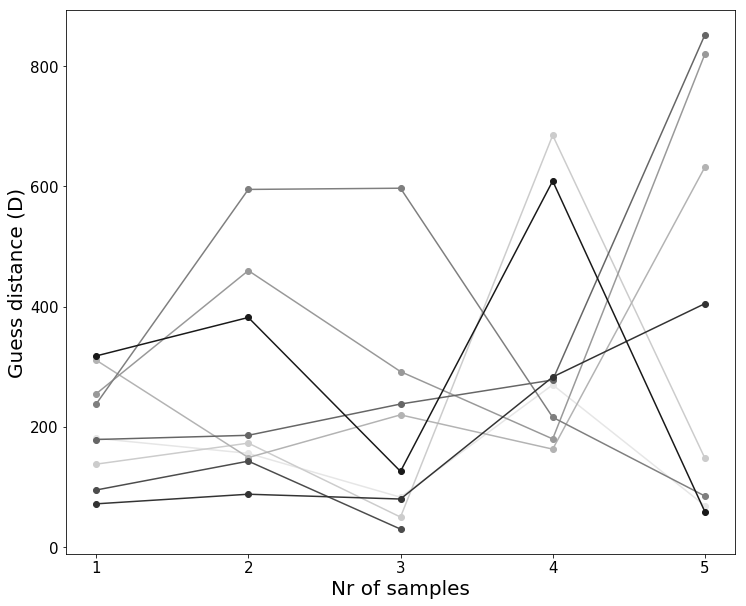

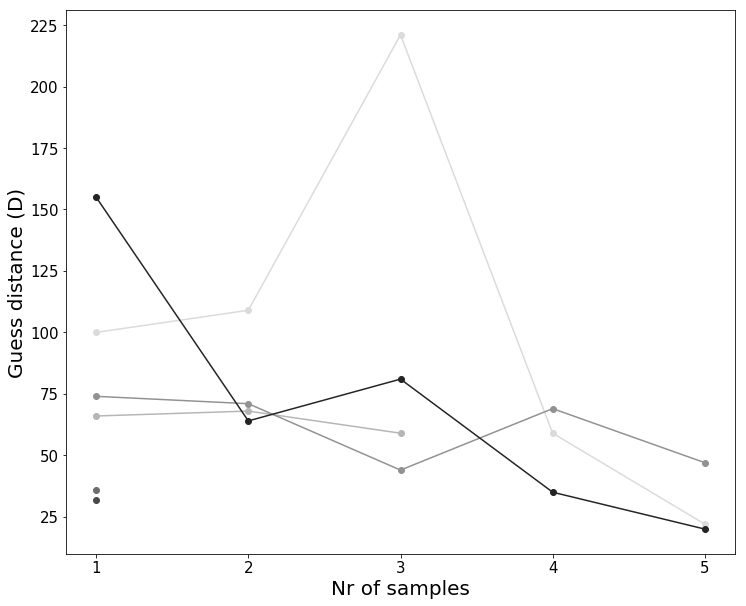

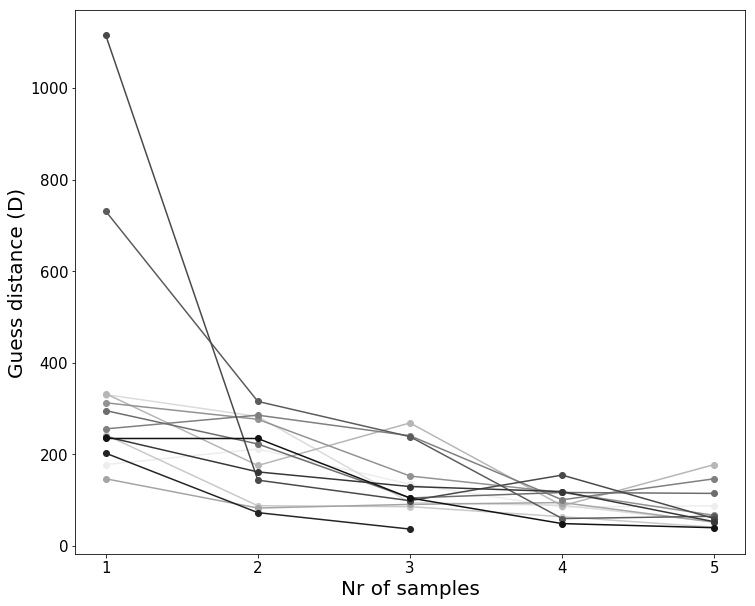

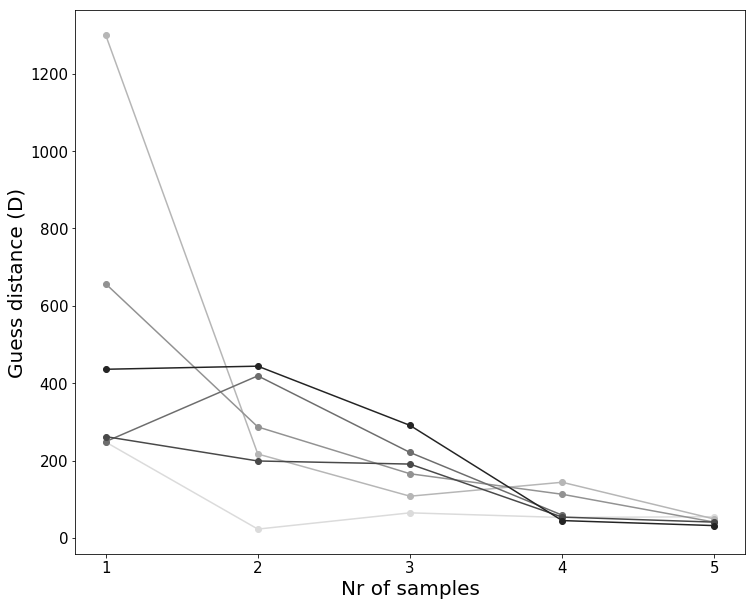

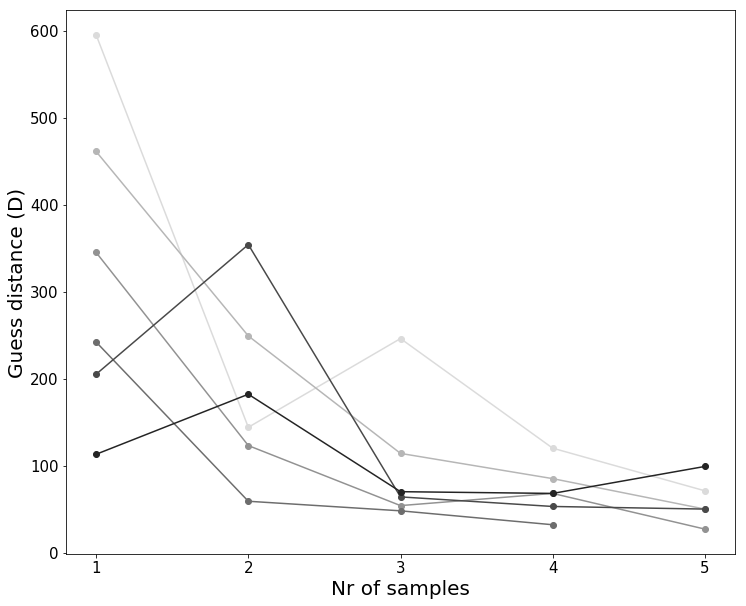

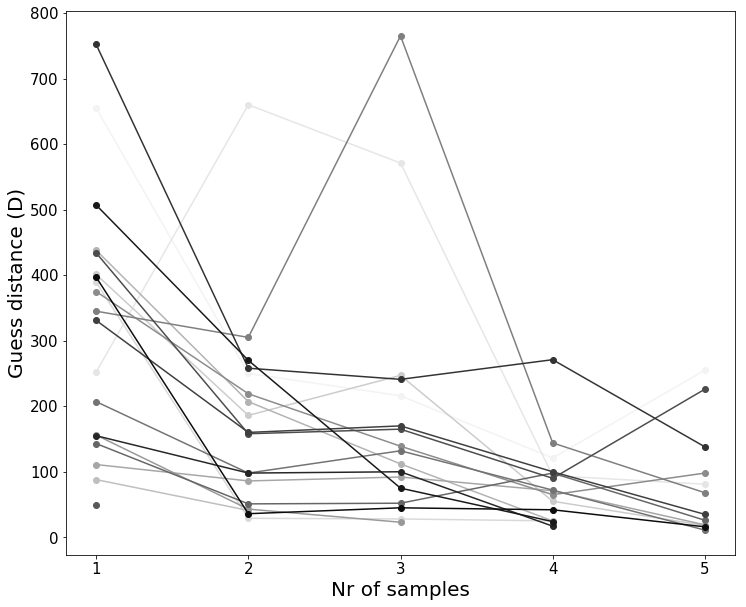

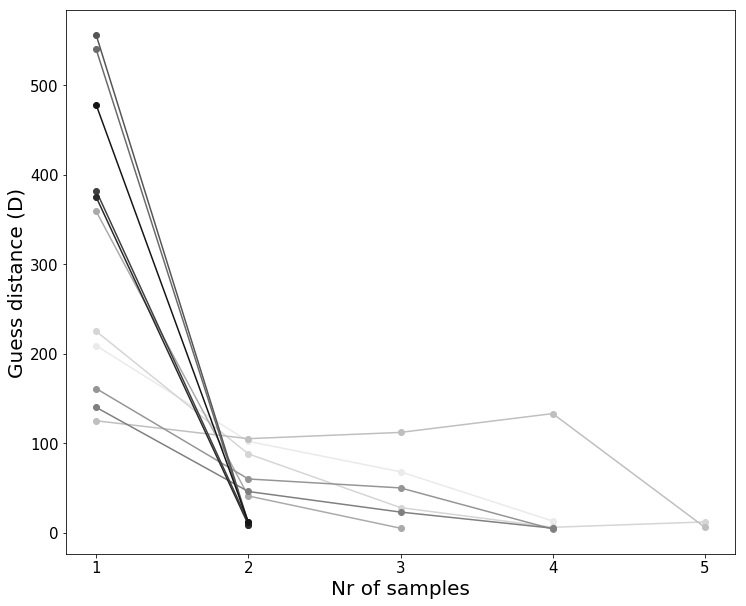

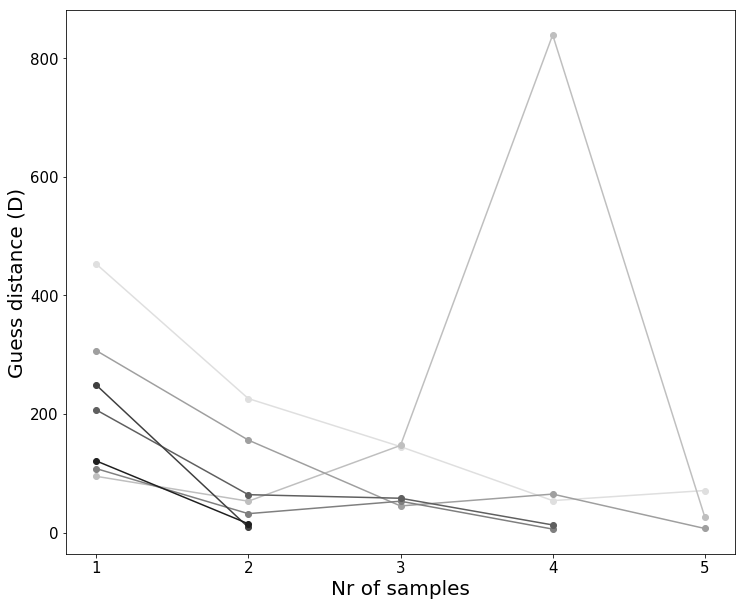

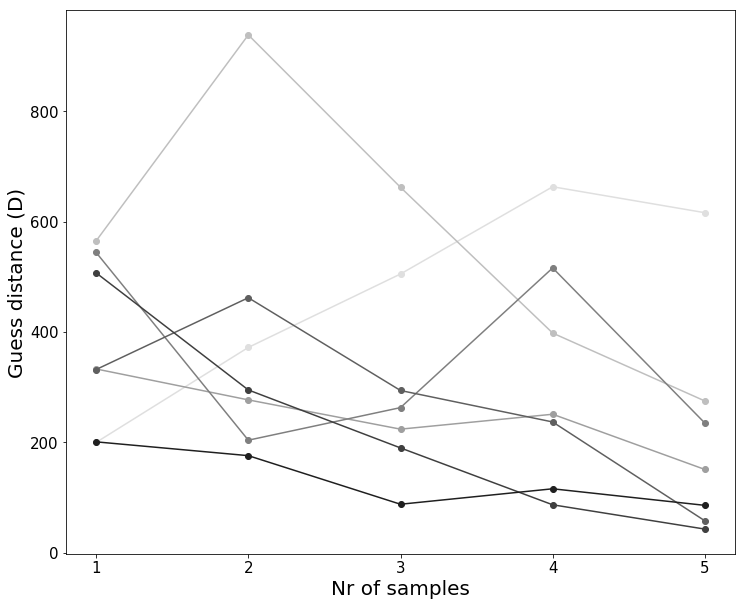

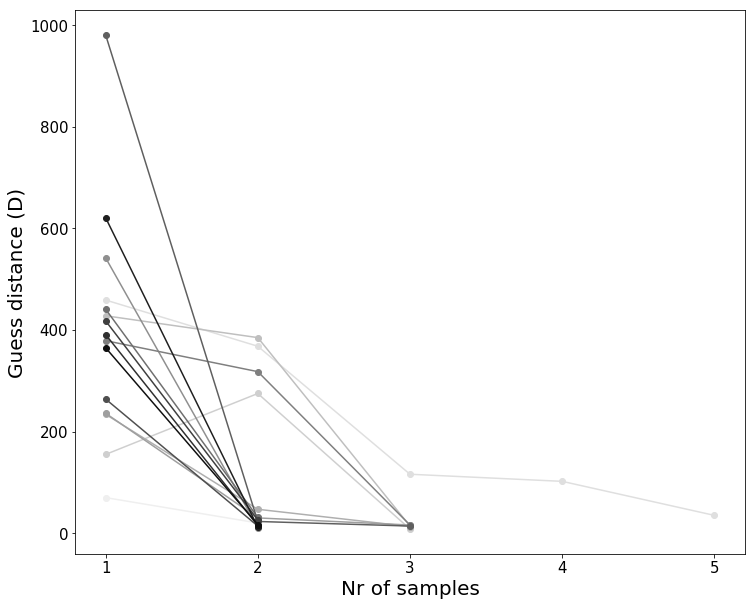

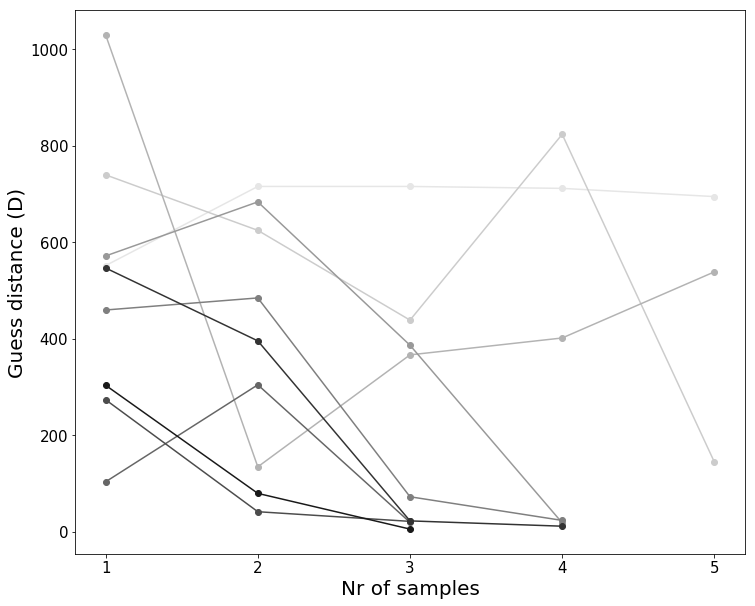

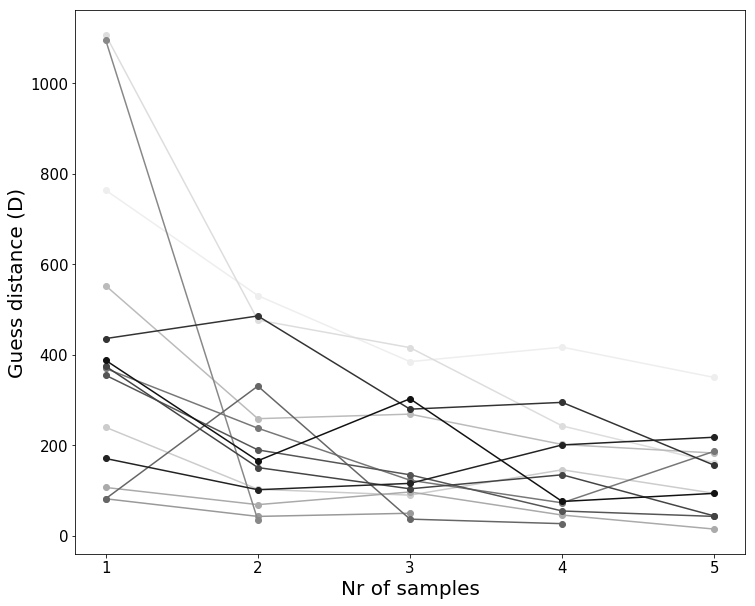

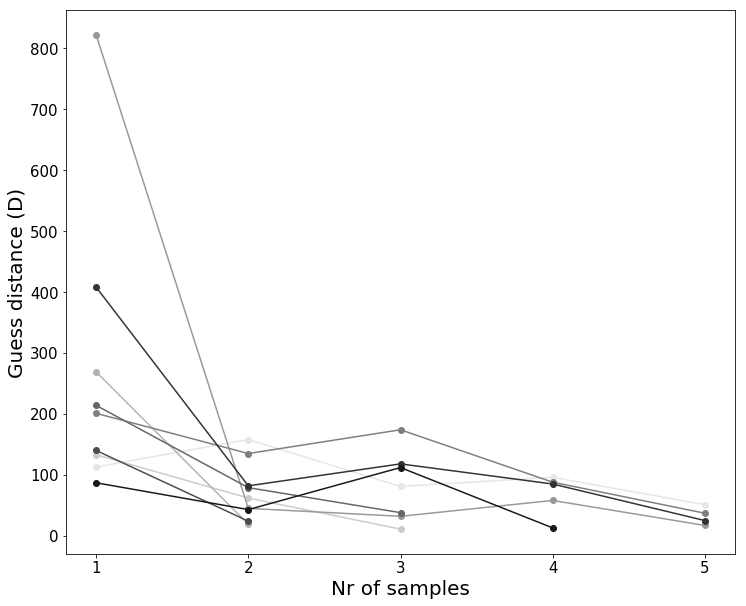

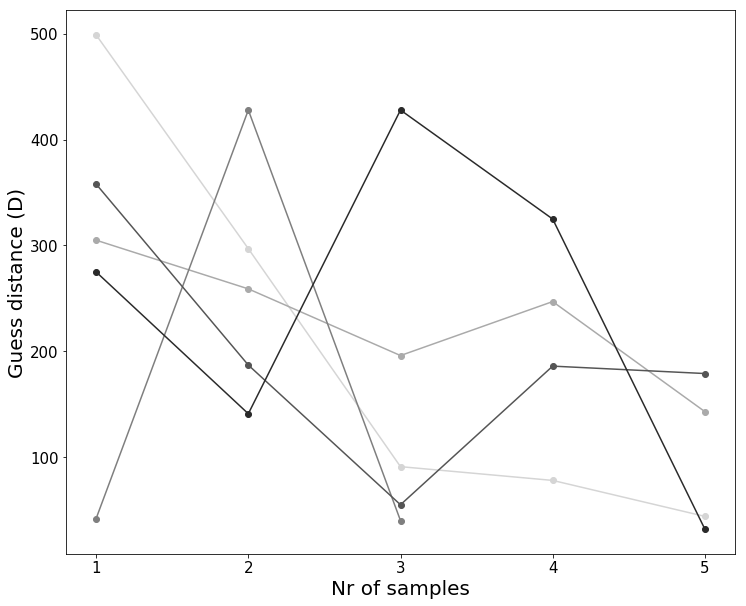

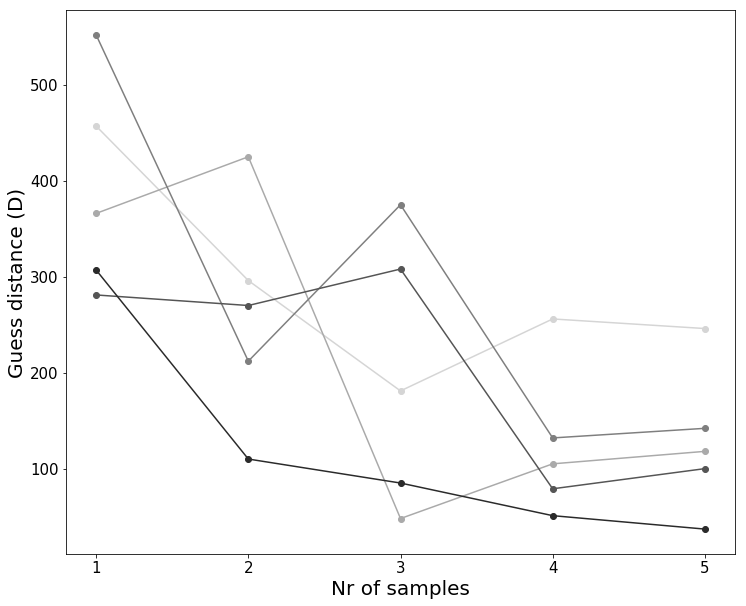

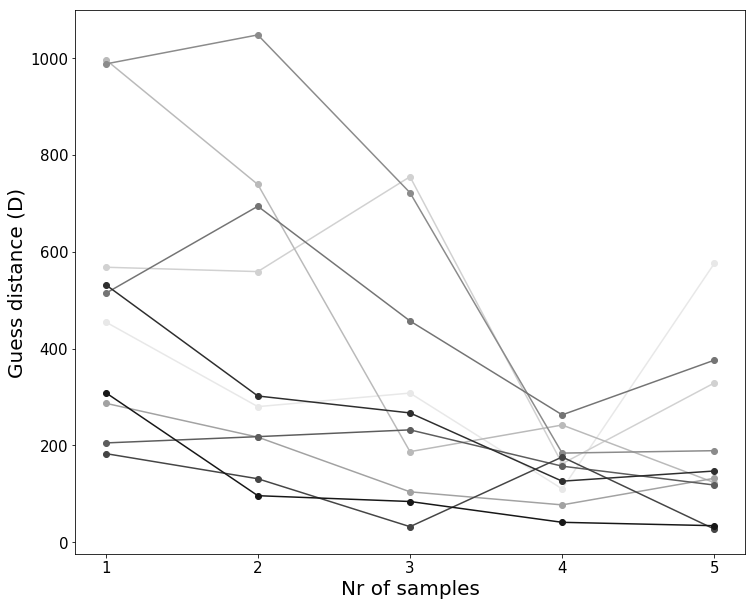

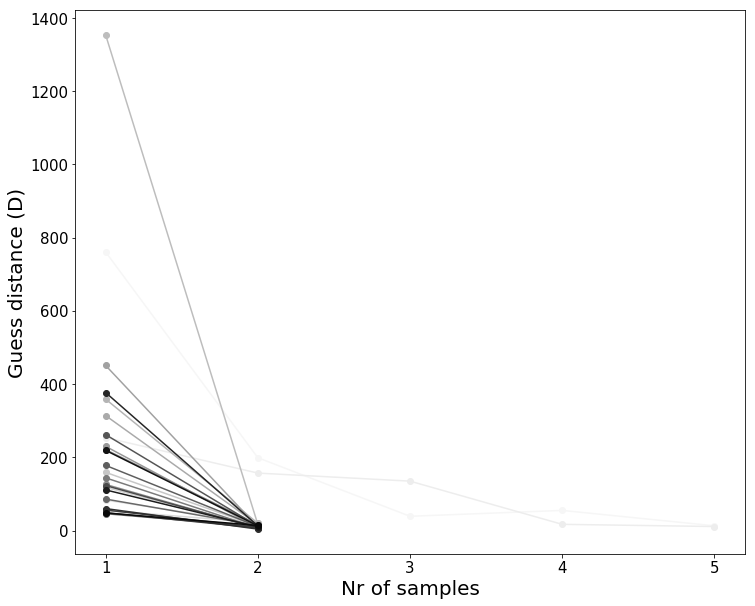

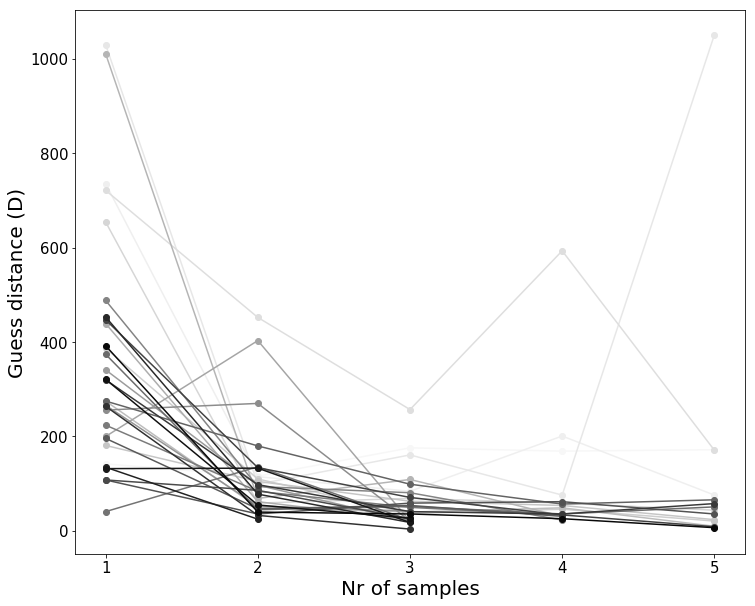

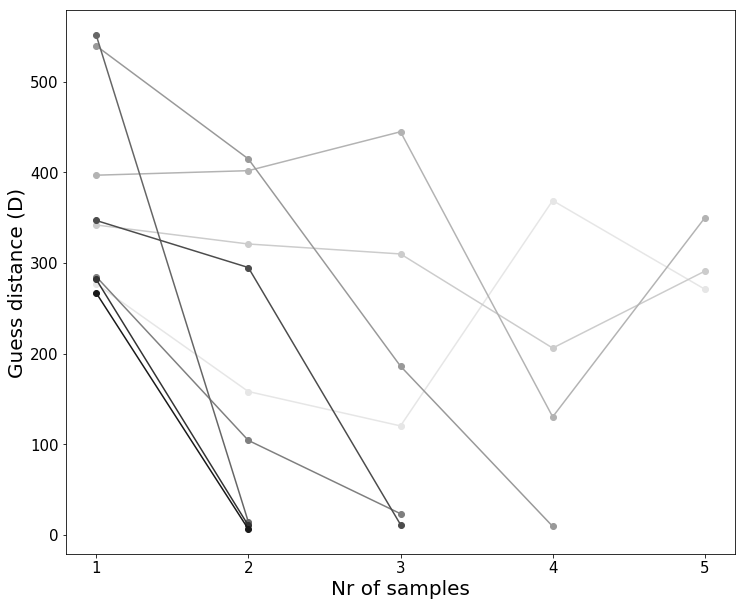

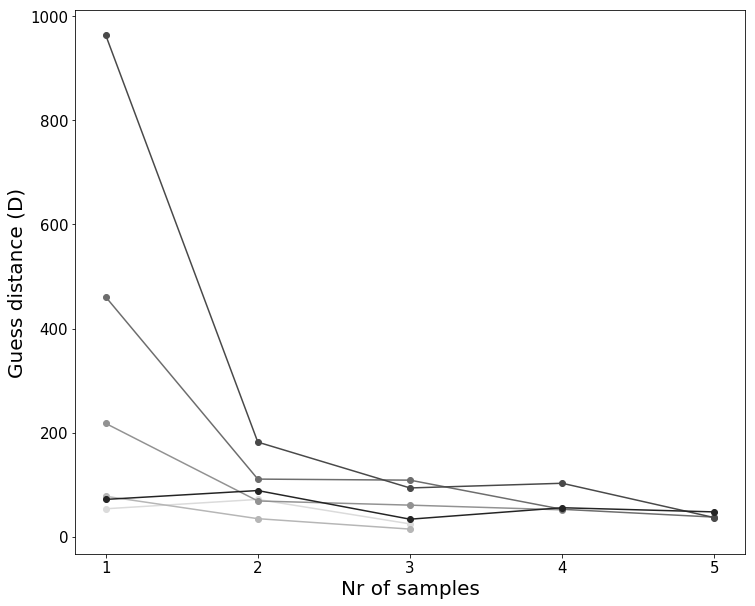

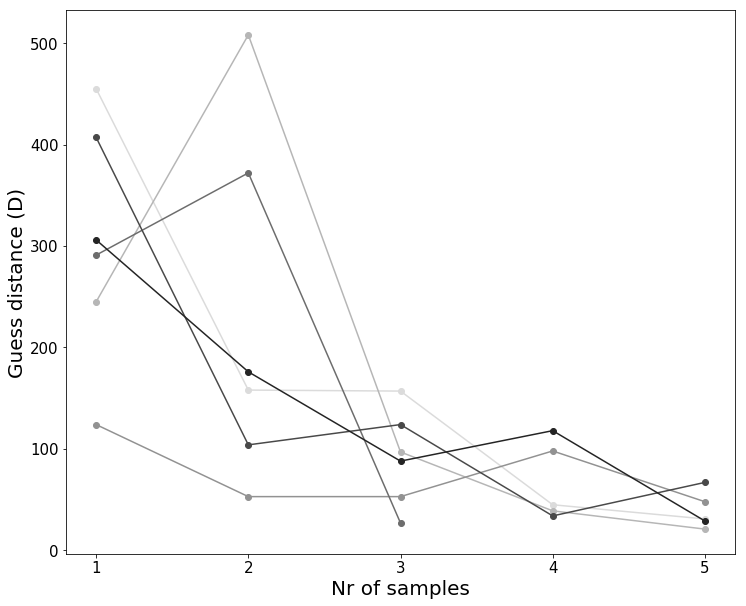

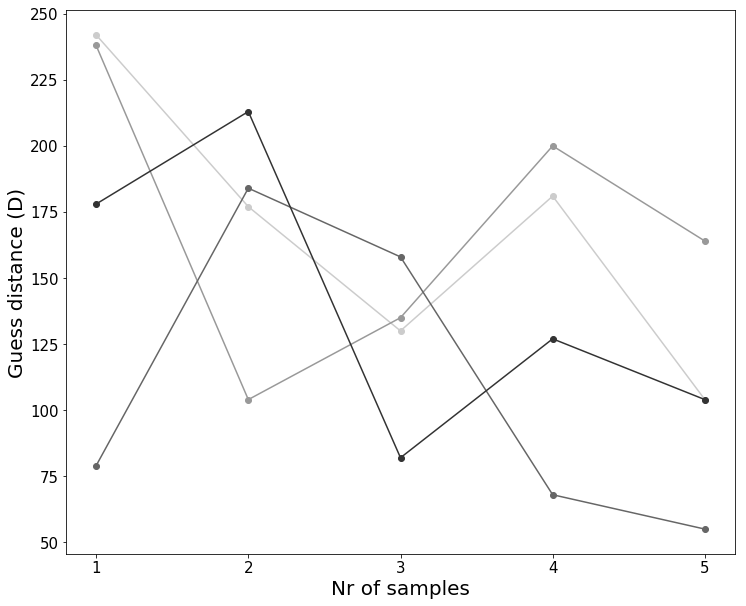

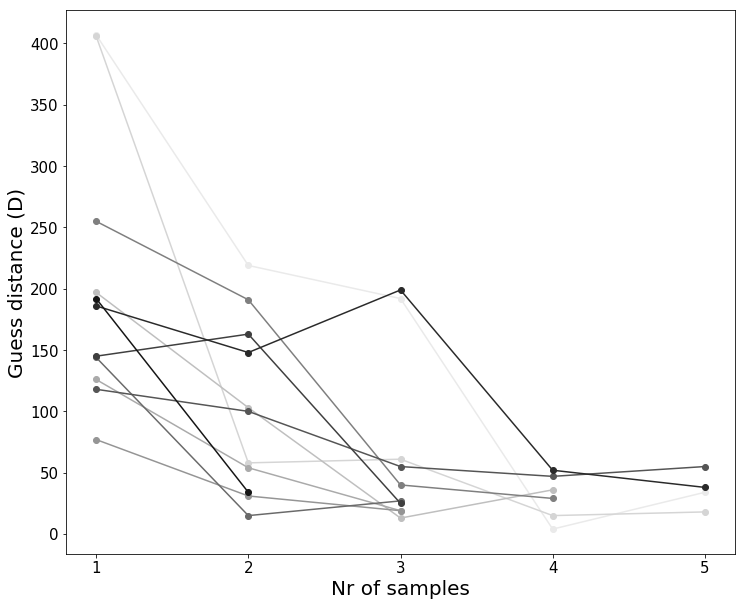

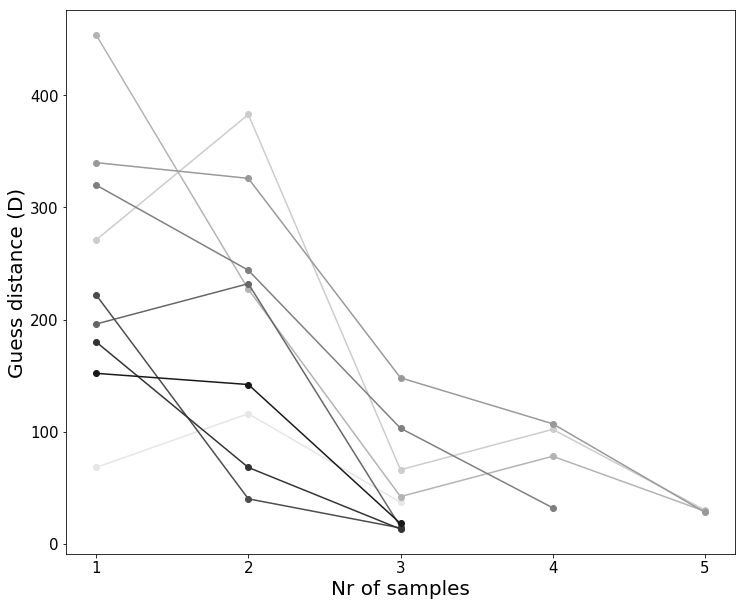

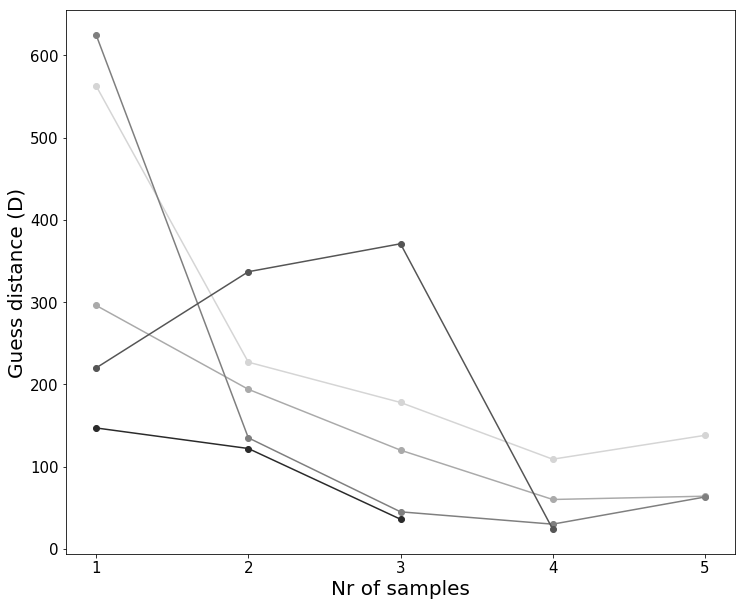

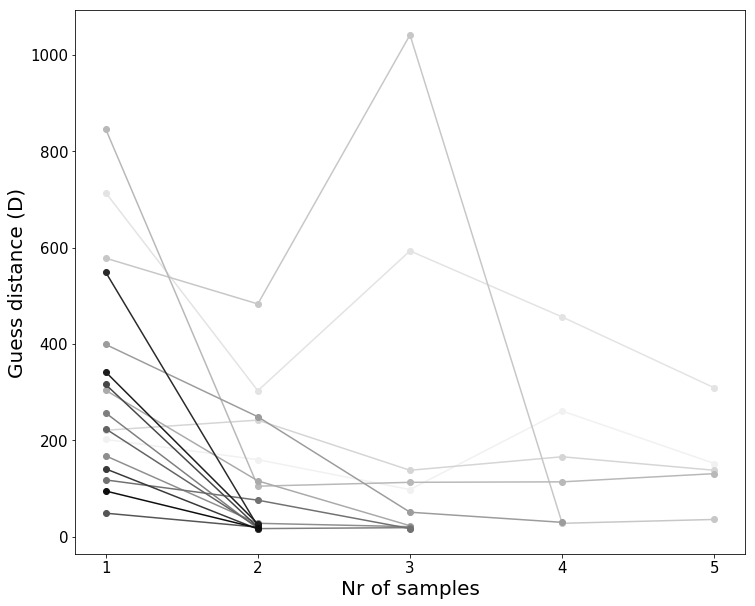

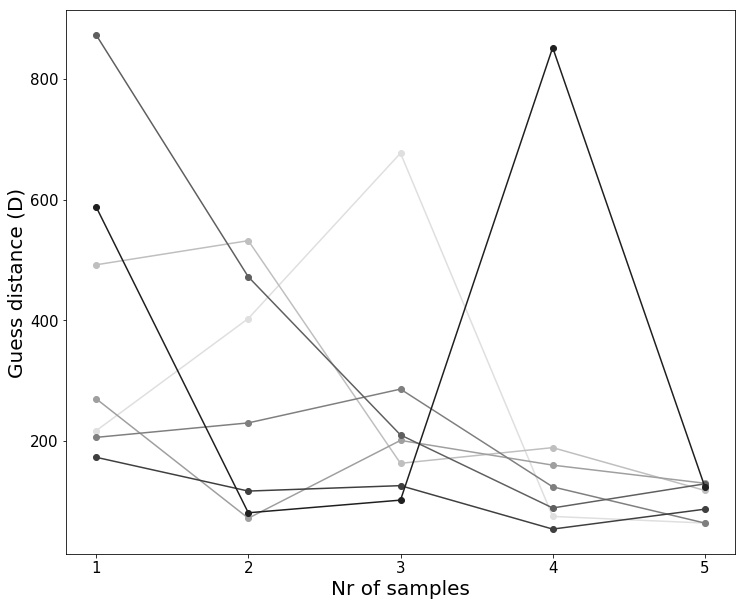

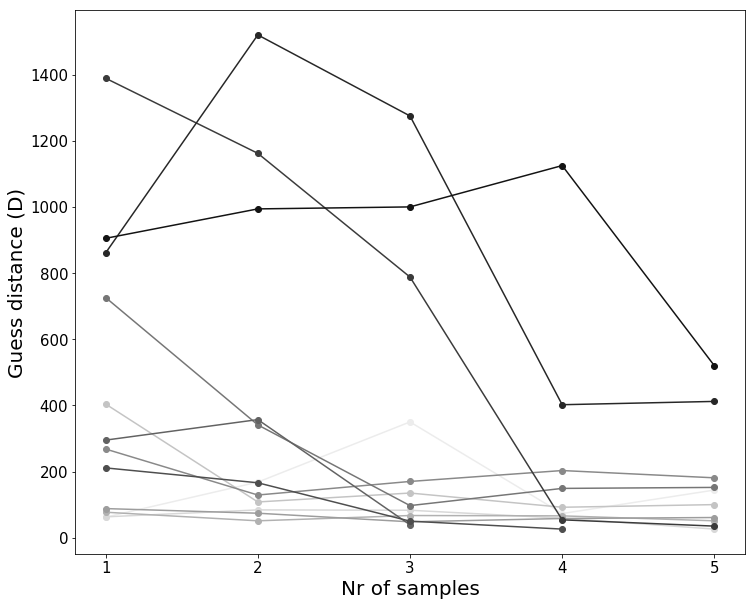

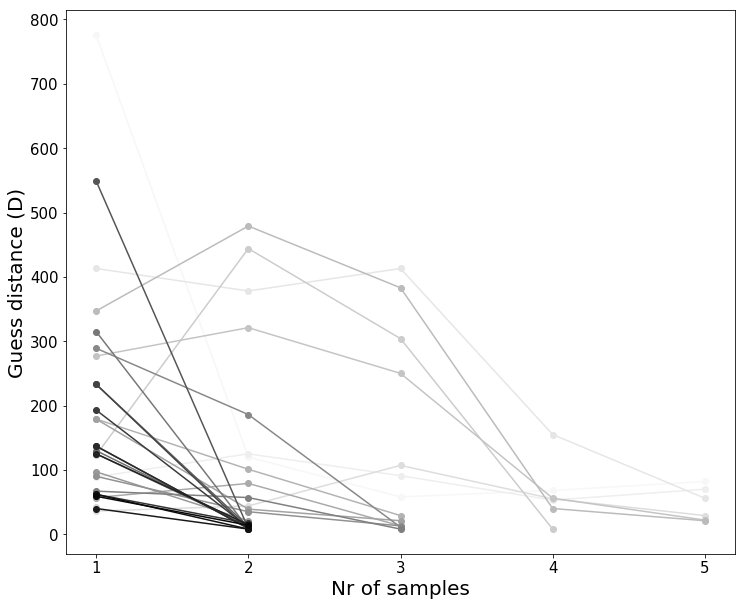

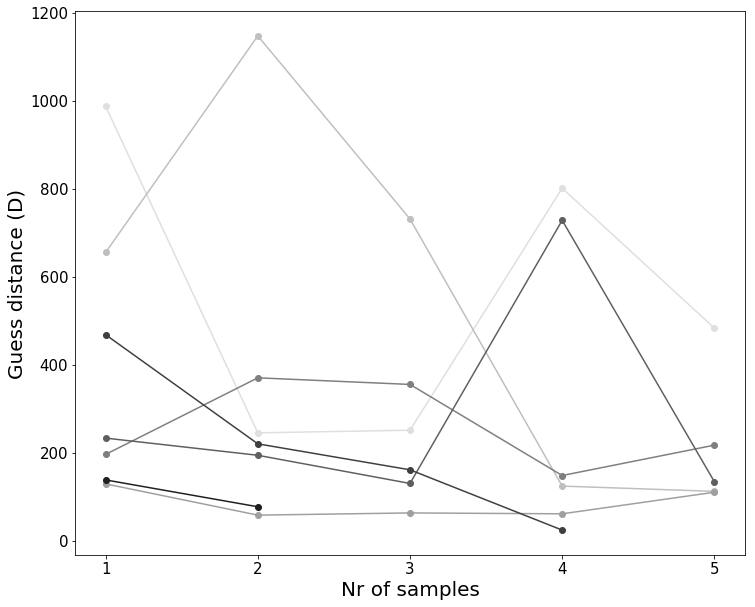

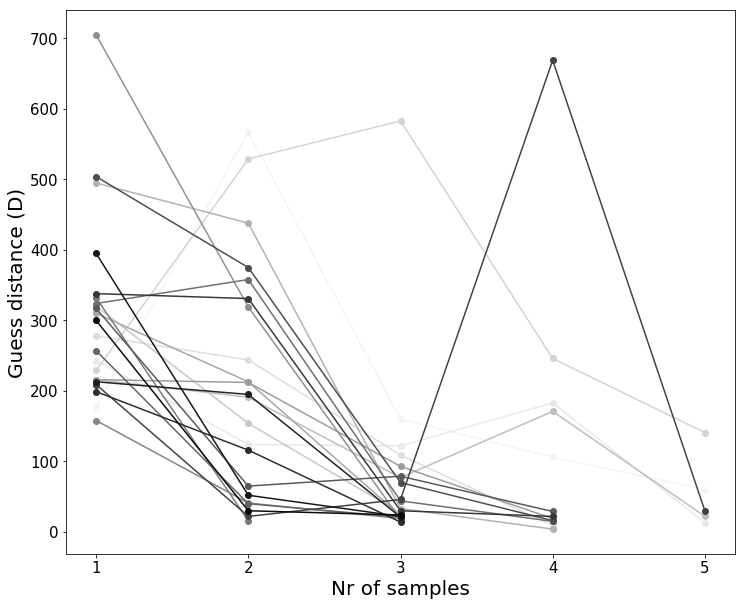

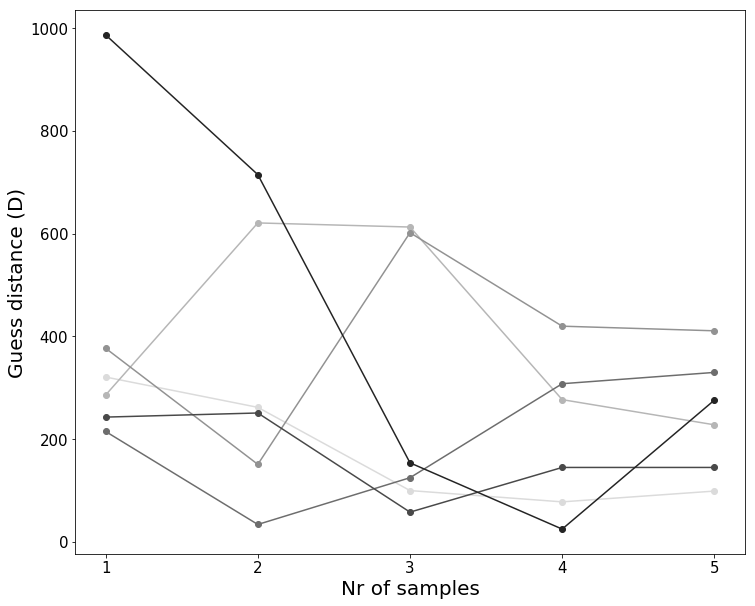

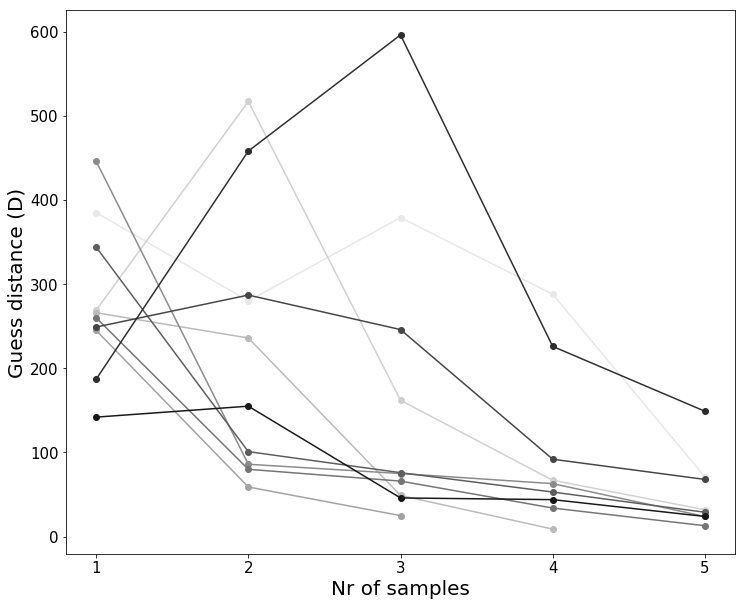

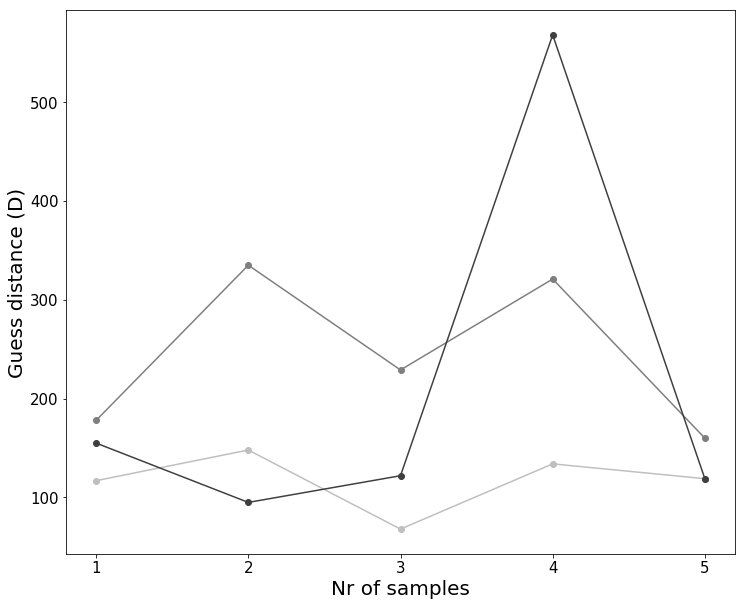

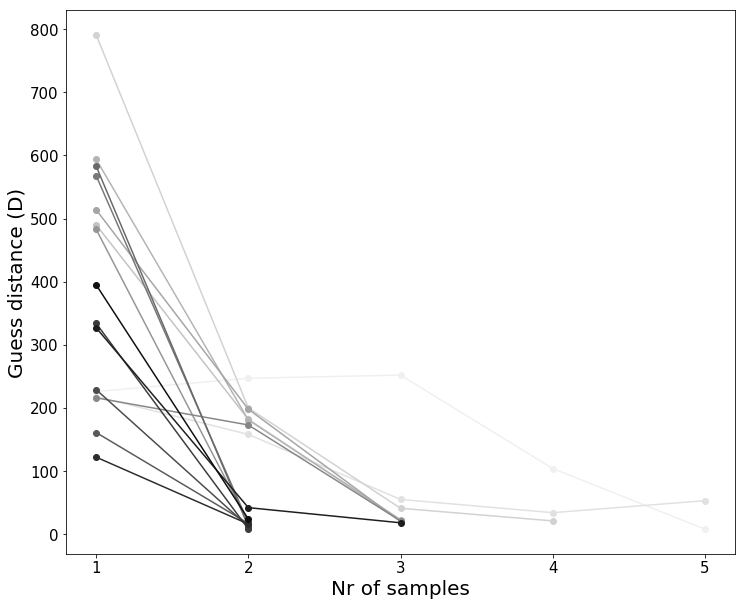

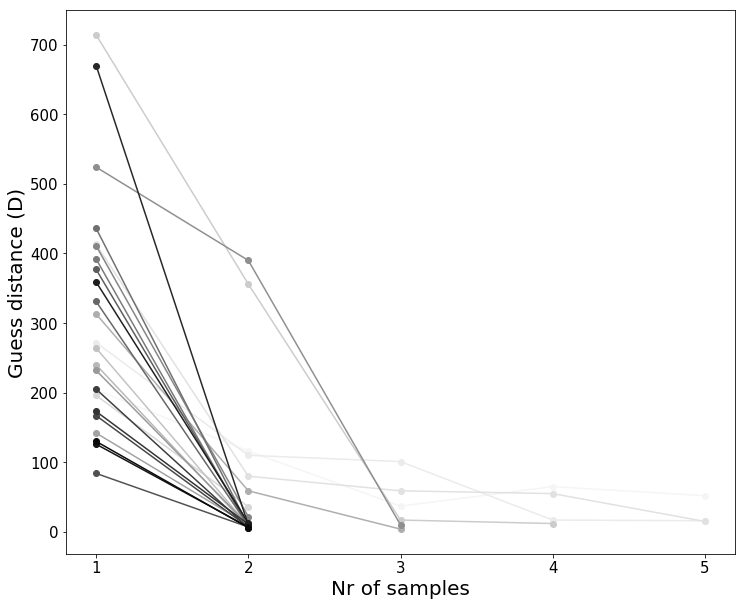

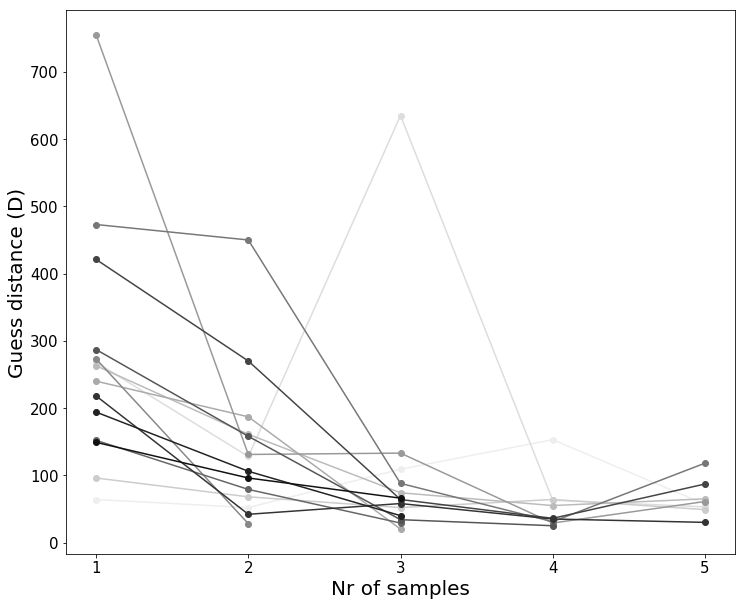

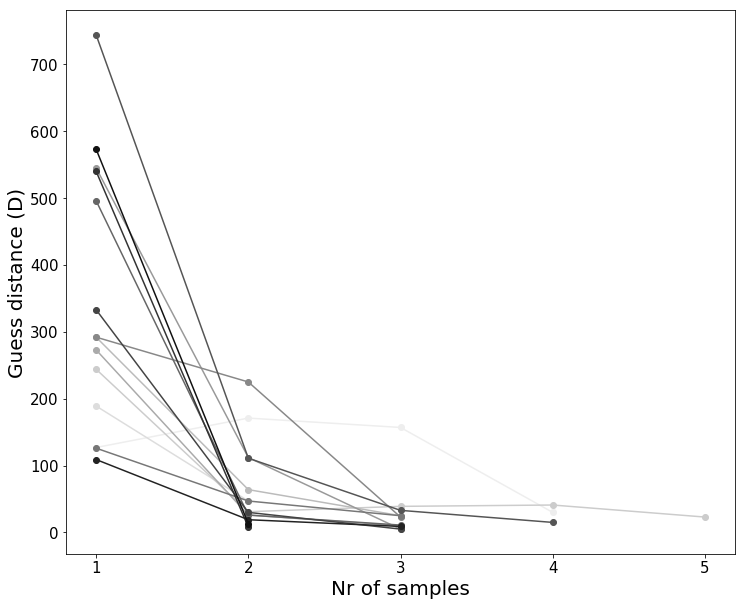

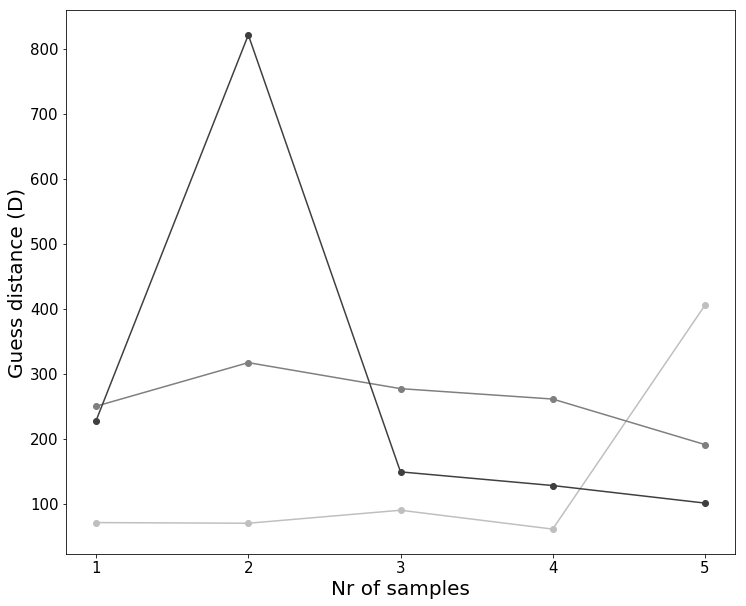

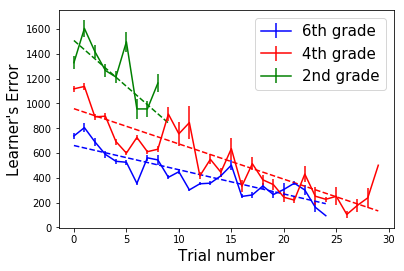

"\nn_samples=[[],[],[]]    \nfor d in Data:        \n    for t in d['Trials']:\n        it+=1\n        true_box=t['Teachers_box']\n        if d['Level']==2:\n            n_samples[0].append(len(t['Examples']))\n        elif d['Level']==4:\n            n_samples[1].append(len(t['Examples']))\n        elif d['Level']==6:\n            n_samples[2].append(len(t['Examples']))\n            \nnp.mean(n_samples[0])            \n"

In [10]:
# DISTANCE FROM THE GUESS TO THE TRUE BOX AS A FUNCTION OF NR SAMPLES AND TRIALS

level=[2,4,6]

cmap = plt.cm.gray_r

n6=0
n4=0
n2=0
max_trial_6=0
max_trial_4=0
max_trial_2=0

min_trial_6=99
min_trial_4=99
min_trial_2=99
for d in Data:            
    if d['Level']==6:
        n6+=1
        max_trial_6=max(max_trial_6,len(d['Trials']))
        min_trial_6=min(min_trial_6,len(d['Trials']))
    elif d['Level']==4:
        n4+=1
        max_trial_4=max(max_trial_4,len(d['Trials']))
        min_trial_4=min(min_trial_4,len(d['Trials']))
    elif d['Level']==2:
        n2+=1
        max_trial_2=max(max_trial_2,len(d['Trials']))
        min_trial_2=min(min_trial_2,len(d['Trials']))

f1=plt.figure()

All_distances_vs_trial_6=np.zeros([n6,max_trial_6])
All_distances_vs_trial_4=np.zeros([n4,max_trial_4])
All_distances_vs_trial_2=np.zeros([n2,max_trial_2])

j6=-1
j4=-1
j2=-1

data_framed={'Id':[],'Level':[],'Trial_Number':[],'DV':[]}
data_framed_dummy={'Id':[],'Level':[],'Trial_0':[],'Trial_1':[],'Trial_2':[],'Trial_3':[],'Trial_4':[],'Trial_5':[],'Trial_6':[],'Trial_7':[],'Trial_8':[],'Trial_9':[],\
                                'Trial_10':[],'Trial_11':[],'Trial_12':[],'Trial_13':[],'Trial_14':[],'Trial_15':[],'Trial_16':[],'Trial_17':[],'Trial_18':[],'Trial_19':[],\
                                'Trial_20':[],'Trial_21':[],'Trial_22':[],'Trial_23':[],'Trial_24':[],'Trial_25':[],'Trial_26':[],'Trial_27':[],'Trial_28':[],'Trial_29':[],'DV':[]}

for d in Data:        
    
    f2=plt.figure(figsize=(12, 10))
    plt.clf();
    if d['Level'] in level:                
        Distances_vs_trial=[]
        it=-1
        norm = matplotlib.colors.Normalize(vmin=-1, vmax=len(d['Trials']))
        for t in d['Trials']:
            it+=1
            true_box=t['Teachers_box']
            distance_vs_n_sample=[]
            for guess in t['Learners_guess']:
                box=guess['box']
                dist=np.abs(box[0]-true_box[0])+np.abs(box[1]-true_box[1])+np.abs(box[2]-true_box[2])+np.abs(box[3]-true_box[3])
                distance_vs_n_sample.append(dist)  
                
            Distances_vs_trial.append(np.sum(distance_vs_n_sample))    
            if not (d['Level']==2 and it>=10):
                data_framed['Id'].append(d['Teachers_Id'])
                data_framed['Level'].append(d['Level'])
                data_framed['Trial_Number'].append(it)
                data_framed['DV'].append(np.sum(distance_vs_n_sample))

            data_framed_dummy['Id'].append(d['Teachers_Id'])
            data_framed_dummy['Level'].append(d['Level'])                        
            data_framed_dummy['DV'].append(np.sum(distance_vs_n_sample))
            
            for t_idx in range(30):
                if t_idx!=it:
                    data_framed_dummy['Trial_'+str(t_idx)].append(0)
                else:
                    data_framed_dummy['Trial_'+str(t_idx)].append(1)
                
            
            
            plt.figure(f2.number)   
            plt.plot(np.array(range(1,len(distance_vs_n_sample)+1)),distance_vs_n_sample,'-o',color=cmap(norm(it)))            
            plt.xticks([1,2,3,4,5])
            plt.tick_params(axis='both', which='major', labelsize=15)
            plt.xlabel('Nr of samples',fontsize=20)
            plt.ylabel('Guess distance (D)',fontsize=20)         
        
        
        if d['Level']==6:
            j6+=1
            All_distances_vs_trial_6[j6,:len(Distances_vs_trial)]=Distances_vs_trial
        elif d['Level']==4:
            j4+=1
            All_distances_vs_trial_4[j4,:len(Distances_vs_trial)]=Distances_vs_trial
        elif d['Level']==2:
            j2+=1
            All_distances_vs_trial_2[j2,:len(Distances_vs_trial)]=Distances_vs_trial
                                    
        plt.show()
        '''        
        plt.figure(f1.number);
        #plt.clf()
        plt.plot(Distances_vs_trial,'-ro')
        plt.xlabel('Trial')
        plt.ylabel('Sum of errors')
        plt.show()
        '''

All_distances_vs_trial_2=All_distances_vs_trial_2[:,:-3]

plt.clf()
fig=plt.figure()

mn=[]
err=[]
for j in range(All_distances_vs_trial_6.shape[1]):
    sample=All_distances_vs_trial_6[All_distances_vs_trial_6[:,j]>0,j]
    n_s=np.sum(All_distances_vs_trial_6[:,j]>0)
    mn.append(np.mean(sample))
    err.append(np.std(sample)/n_s)
    
plt.errorbar(range(len(mn)),mn,err,color='b')

mn=[]
err=[]
for j in range(All_distances_vs_trial_4.shape[1]):
    sample=All_distances_vs_trial_4[All_distances_vs_trial_4[:,j]>0,j]
    n_s=np.sum(All_distances_vs_trial_4[:,j]>0)
    mn.append(np.mean(sample))
    err.append(np.std(sample)/n_s)
    
plt.errorbar(range(len(mn)),mn,err,color='r')

mn=[]
err=[]
for j in range(All_distances_vs_trial_2.shape[1]):
    sample=All_distances_vs_trial_2[All_distances_vs_trial_2[:,j]>0,j]
    n_s=np.sum(All_distances_vs_trial_2[:,j]>0)
    mn.append(np.mean(sample))
    err.append(np.std(sample)/n_s)
    
plt.errorbar(range(len(mn)),mn,err,color='g')
plt.legend(['6th grade','4th grade','2nd grade'],fontsize='15')

I2=1507.4957
I4=I2-550.1874
I6=I2-847.3417
slope_2=-73.9588
slope_4=slope_2+45.5169
slope_6=slope_2+ 54.4068 

x_aux=np.array(range(10))
y_2=x_aux*slope_2+I2
plt.plot(x_aux,y_2,'--g')

x_aux=np.array(range(30))
y_4=x_aux*slope_4+I4
plt.plot(x_aux,y_4,'--r')

x_aux=np.array(range(25))
y_6=x_aux*slope_6+I6
plt.plot(x_aux,y_6,'--b')

plt.xlabel('Trial number',fontsize=15)
plt.ylabel("Learner's Error",fontsize=15)

plt.show()    

#fig.savefig('L_error_vs_trial.png',dpi=300)

###############################################        
'''
n_samples=[[],[],[]]    
for d in Data:        
    for t in d['Trials']:
        it+=1
        true_box=t['Teachers_box']
        if d['Level']==2:
            n_samples[0].append(len(t['Examples']))
        elif d['Level']==4:
            n_samples[1].append(len(t['Examples']))
        elif d['Level']==6:
            n_samples[2].append(len(t['Examples']))
            
np.mean(n_samples[0])            
'''                        

In [148]:
#fig.savefig('L_error_vs_trial.png',dpi=300)

array([    0.,     0.,     0.,     0.,     0.,     0.,   670.,   911.,
        1141.,  1603.,  1494.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.])

In [179]:
import pandas as pd
DF=pd.DataFrame(data= data_framed)
DF.to_csv('data_teachers_continuous_time.csv')

In [ ]:
df.join(pd.get_dummies(df.index.get_level_values(0).weekday_name)

In [95]:
DF['Trial_Number'].

0       0
1       1
2       2
3       3
4       4
5       5
6       6
7       7
8       8
9       9
10     10
11     11
12     12
13     13
14     14
15      0
16      1
17      2
18      3
19      4
20      5
21      6
22      7
23      8
24      9
25     10
26     11
27     12
28     13
29      0
       ..
667     1
668     2
669     3
670     4
671     5
672     6
673     7
674     8
675     9
676    10
677    11
678    12
679    13
680     0
681     1
682     2
683     3
684     4
685     5
686     6
687     7
688     8
689     9
690    10
691    11
692    12
693    13
694     0
695     1
696     2
Name: Trial_Number, Length: 697, dtype: int64

Statistics on the raw data

In [ ]:
levels=[]

all_dists=[]
CDF_per_subject=[]
axis=np.linspace(0,600,300)

n6=0
n4=0
n2=0

for d in Data:
    levels.append(d['Level'])
    distances=[]
    for t in d['Trials']:
        rectangle=t['Teachers_box']
        for e in t['Examples']:
            distances.append(distance_to_corners(rectangle,[(e['x'],e['y'])]))    
    x_data,cum_prob=cdf(distances)
    cum_prob_fixed_axis=cdf_fixing_x_axis(distances,axis)
    CDF_per_subject.append({'Level':d['Level'],'cdf':cum_prob_fixed_axis})
    
    if d['Level']==6:
        n6+=1
        plt.plot(x_data,cum_prob,'k')
    elif d['Level']==4:
        n4+=1
        plt.plot(x_data,cum_prob,'r')
    elif d['Level']==2:        
        n2+=1
        plt.plot(x_data,cum_prob,'g') 
plt.show()
            
level_data=[]

Prob6=np.zeros([n6,len(axis)])
Prob4=np.zeros([n4,len(axis)])
Prob2=np.zeros([n2,len(axis)])

j6=0
j4=0
j2=0

for d in CDF_per_subject:

    if d['Level']==6:        
        Prob6[j6,:]=d['cdf']
        j6+=1
    elif d['Level']==4:
        Prob4[j4,:]=d['cdf']
        j4+=1
    elif d['Level']==2:        
        Prob2[j2,:]=d['cdf']
        j2+=1
        
mnP6=np.mean(Prob6,axis=0)        
sdP6=np.std(Prob6,axis=0)/n6

mnP4=np.mean(Prob4,axis=0)        
sdP4=np.std(Prob4,axis=0)/n4

mnP2=np.mean(Prob2,axis=0)        
sdP2=np.std(Prob2,axis=0)/n2




fig=plt.figure()
plt.clf()
plt.plot(axis, mnP6, 'b')
plt.fill_between(axis, mnP6-sdP6, mnP6+sdP6,alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(axis, mnP4, 'r')
plt.fill_between(axis, mnP4-sdP4, mnP4+sdP4,alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(axis, mnP2, 'g')
plt.fill_between(axis, mnP2-sdP2, mnP2+sdP2,alpha=0.5, edgecolor='g', facecolor='g')

plt.legend(['6th grade','4th grade','2nd grade'],fontsize=15)
plt.xlabel('Distance',fontsize=15)
plt.ylabel('CDF',fontsize=15)


plt.show()
fig.savefig('Distance_to_corners.png')

    
    
    
# individual_histogram(Pair,reference_box='teacher')            
            

In [ ]:
# DISTANCE TO CORNERS WRT GUESSED RECTANGLE

levels=[]

all_dists=[]
CDF_per_subject=[]
axis=np.linspace(0,600,300)

n6=0
n4=0
n2=0

for d in Data:
    levels.append(d['Level'])
    distances=[]
    for t in d['Trials']:        
        for i in range(len(t['Examples'])):
            rectangle=t['Learners_guess'][i]['box']
            for j in range(0,i+1):
                distances.append(distance_to_corners(rectangle,[(t['Examples'][j]['x'],t['Examples'][j]['y'])]))
    
    x_data,cum_prob=cdf(distances)
    cum_prob_fixed_axis=cdf_fixing_x_axis(distances,axis)
    CDF_per_subject.append({'Level':d['Level'],'cdf':cum_prob_fixed_axis})
    
    if d['Level']==6:
        n6+=1
        plt.plot(x_data,cum_prob,'k')
    elif d['Level']==4:
        n4+=1
        plt.plot(x_data,cum_prob,'r')
    elif d['Level']==2:        
        n2+=1
        plt.plot(x_data,cum_prob,'g') 
    
plt.show()
            
level_data=[]

Prob6=np.zeros([n6,len(axis)])
Prob4=np.zeros([n4,len(axis)])
Prob2=np.zeros([n2,len(axis)])

j6=0
j4=0
j2=0

for d in CDF_per_subject:

    if d['Level']==6:        
        Prob6[j6,:]=d['cdf']
        j6+=1
    elif d['Level']==4:
        Prob4[j4,:]=d['cdf']
        j4+=1
    elif d['Level']==2:        
        Prob2[j2,:]=d['cdf']
        j2+=1
        
mnP6=np.mean(Prob6,axis=0)        
sdP6=np.std(Prob6,axis=0)/n6

mnP4=np.mean(Prob4,axis=0)        
sdP4=np.std(Prob4,axis=0)/n4

mnP2=np.mean(Prob2,axis=0)        
sdP2=np.std(Prob2,axis=0)/n2


fig=plt.figure()
plt.clf()
plt.plot(axis, mnP6, 'b')
plt.fill_between(axis, mnP6-sdP6, mnP6+sdP6,alpha=0.5, edgecolor='b', facecolor='b')

plt.plot(axis, mnP4, 'r')
plt.fill_between(axis, mnP4-sdP4, mnP4+sdP4,alpha=0.5, edgecolor='r', facecolor='r')

plt.plot(axis, mnP2, 'g')
plt.fill_between(axis, mnP2-sdP2, mnP2+sdP2,alpha=0.5, edgecolor='g', facecolor='g')

plt.legend(['6th grade','4th grade','2nd grade'],fontsize=15)
plt.xlabel('Distance',fontsize=15)
plt.ylabel('CDF',fontsize=15)


plt.show()
fig.savefig('Distance_to_corners_guessed_boxes.png')

    
    
    
# individual_histogram(Pair,reference_box='teacher')            
            

In [ ]:
# LOAD DISCRETIZED DATA

Data_discretized=load_obj('Total_SK_Data_discretized_with_some_dist');

In [ ]:
# CHECK CORRECT DISCRETIZED BOXES            

error_counter=0
non_solved=0
for d in Data_discretized:
    for t in d['Trials']:
        j=-1
        for guess in t['Learners_guess']:            
            j+=1
            box=guess['box']
            problems=False
            
            for i in range(0,j+1):
                e=t['Examples'][i]
                if guess['consistency']:
                    if e['inside']=='true' and (e['x']<box[0] or e['x']>=box[1] or e['y']<box[2] or e['y']>=box[3]):
                        problems=True
                        error_counter+=1
                        '''
                        print('--------------------------')
                        print('Box:',box)
                        print('Inside:',e['inside'])
                        print('Example:',(e['x'],e['y']))
                        '''                                                                                                                                                         
                        
                    if e['inside']=='false' and not (e['x']<box[0] or e['x']>=box[1] or e['y']<box[2] or e['y']>=box[3]):
                        problems=True
                        error_counter+=1
                        
                        '''
                        print('--------------------------')                        
                        print('Box:',box)
                        print('Inside:',e['inside'])
                        print('Examples:',t['Examples'])
                        '''
            if problems:                
                [new_box, worked]=correct_discretized_boxes(box,t['Examples'])
                guess['box']=new_box
                '''
                print('New box:',new_box)
                print('Worked:', worked)                
                print('######################################')
                '''
                if not worked:
                    non_solved+=1
                        
                        
                        
                        

In [ ]:

# CREATE M

grid_size=25
min_size=1

t0=time.time()
[M,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size)
t1=time.time()
print(t1-t0)


# SAVE M
'''
sparse.save_npz('sparse_M_grid_'+str(grid_size )+'_min_box'+str(min_size)+'.npz', M)
save_obj(H_space, 'H_space_grid_'+str(grid_size )+'_min_box'+str(min_size))
save_obj(Examples, 'Examples_grid_'+str(grid_size ))
'''

# LOAD
'''
t0=time.time()
M = sparse.load_npz('sparse_M_grid_'+str(grid_size )+'_min_box'+str(min_size)+'.npz')
t1=time.time()
print('Time to load M:',t1-t0)
H_space=load_obj('H_space_grid_'+str(grid_size )+'_min_box'+str(min_size))
Examples=load_obj('Examples_grid_'+str(grid_size ))
'''

In [ ]:
# SEE TRIALS
for d in Data:
    if d['Level']==2:
        print('!!!!!!!!!!!!!! NEW SUBJECTS !!!!!!!!!!!!!!!')
        print('!!!!!!!!!!!!!! LEVEL:',d['Level'],'!!!!!!!!!!!!')
        for t in d['Trials']:
            print('##############  NEW TRIAL   ###############')
            samples=[]
            circle=[]
            j=-1
            for e in t['Examples']:
                j+=1
                last_guess=t['Learners_guess'][j]['box']
                samples.append((e['x'],e['y']))
                circle.append(check_if_inside(samples[-1],t['Teachers_box']))
                plot_trial(tuple(t['Teachers_box']),samples,circle,616,last_guess=last_guess)


In [ ]:
samples

In [ ]:
# ANALYSIS AT LOWER RESOLUTION

grid_size=15
min_size=1

print('Creating M')
t0=time.time()
[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size,smooth=['exp',1])
#[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size)
t1=time.time()
print('Done in:',t1-t0)

#[TL_start,relative_distance,converged]=get_TL_sparse(M_start)

'''
true_hypothesis=(7,12,7,12)
h_idx=H_space.index(true_hypothesis)
samples=[]
circle=[]
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)  
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)
'''

In [ ]:
M_norm=M_start/M_start.sum()

In [ ]:
true_hypothesis=(3,8,3,8)
h_idx=H_space.index(true_hypothesis)


plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_norm.sum(axis=1).reshape([len(Examples)*2,1])),separate_in_out=True)  
TL_start=normalize(M_start,norm='l1',axis=1)

for it in range(10):
    TL_start=normalize(TL_start,norm='l1',axis=0)
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL_start.sum(axis=1).reshape([len(Examples)*2,1])),separate_in_out=True)  
    TL_start=normalize(TL_start,norm='l1',axis=1)

In [ ]:
np.min(TL_start.sum(axis=1))

In [ ]:
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_norm.sum(axis=1).reshape([len(Examples)*2,1])),separate_in_out=True)  
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL_start.sum(axis=1).reshape([len(Examples)*2,1])),separate_in_out=True)  

In [ ]:
H_space[-10:]

In [ ]:
np.max(M_start.data)

In [ ]:
sample=(12,9)
print('sample:',sample)
print('rectangle:',true_hypothesis)
print('distance:',distance_to_box(sample,true_hypothesis))
rectangle=true_hypothesis


In [ ]:
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)

In [ ]:
M_start[Examples.index((12,9))+grid_size**2,h_idx]

In [ ]:
# ANALYSIS AT LOWER RESOLUTION

grid_size=15
min_size=1

print('Creating M')
t0=time.time()
[M_start,Examples,H_space]=define_hyp_and_examples_space(grid_size,min_size)
t1=time.time()
print('Done in:',t1-t0)

[TL_start,relative_distance,converged]=get_TL_sparse(M_start)


true_hypothesis=(7,12,7,12)
h_idx=H_space.index(true_hypothesis)
samples=[]
circle=[]
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)  
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_t=True)


Move_Id_Repeated_sample=[] 
Exceptions=[]



CI=[]
Teachers_entropy=[]
Sample_information=[]
Learners_entropy=[]
Guess_information=[]

for it in range(5):

    M=M_start.copy()
    TL=TL_start.copy()
    
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)
    
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)
    
    
    s_input= input("Select new sample in format x,y")
    new_sample=tuple(map(int,s_input.split(',')))
    samples.append(new_sample)

    sample_idx=Examples.index(new_sample)
    
    if check_if_inside(new_sample,true_hypothesis):        
        circle.append(True)
    else:
        sample_idx+=grid_size**2
        circle.append(False)
        
    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)                         

    Teachers_entropy.append(-np.sum(np.multiply(TL[:,h_idx].data,np.log(TL[:,h_idx].data))))
    
    Sample_information.append(-np.log(TL[sample_idx,h_idx]))

    box_input= input("Guess the box in format x_left,x_right,y_bottom,y_top")
    
    new_box=tuple(map(int,box_input.split(',')))
    box_idx=H_space.index(new_box)                                                                                                    


    L=normalize(TL,norm='l1',axis=1)                               
    P_learner=L[sample_idx,:];                
    ci=(TL.multiply(L)).sum()
    L=[]
                    
    CI.append(ci/len(H_space))    
                
    Learners_entropy.append( -np.sum(np.multiply(P_learner.data,np.log(P_learner.data))) )
    Guess_information.append(-np.log(P_learner[0,box_idx]))

    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),last_guess=H_space[box_idx],separate_in_out=True)                     

    if any(M[sample_idx,:].data): 
        M=M.multiply(sparse.csr_matrix(np.ones([M.shape[0],1])) * M[sample_idx,:])
        M[sample_idx,:]=0
        M[:,box_idx]=0
        M.eliminate_zeros()
        [TL,relative_distance,converged]=get_TL_sparse(M)
    else:                
        print('Repeated sample: Skipping the Actualization of M and TL')
        Move_Id_Repeated_sample.append(e['move_Id'])
        save_obj(Move_Id_Repeated_sample,'Move_Id_Repeated_sample')
                        
    print('Non-zeros in M:',len(M.data)/1000000,' x 10^6')

    




In [ ]:
plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(M_start[:,h_idx].todense().reshape([len(Examples)*2,1])),separate_in_out=True)

In [ ]:
np.array(Examples)[np.where(np.array((M_start[:,h_idx]==1).todense())),:]

In [ ]:
np.where(np.array((M_start[:,h_idx]==1).todense()))

Load Grid Spaces for SK-iteration process

In [ ]:
grid_size=30
min_size=1
t0=time.time()
M_start = sparse.load_npz('Grid_spaces/sparse_M_grid_'+str(grid_size )+'_min_box'+str(min_size)+'.npz')
t1=time.time()
print('Time to load M:',t1-t0)
H_space=load_obj('Grid_spaces/H_space_grid_'+str(grid_size )+'_min_box'+str(min_size))
Examples=load_obj('Grid_spaces/Examples_grid_'+str(grid_size ))
[TL_start,relative_distance,converged]=get_TL_sparse(M_start)



In [ ]:
T_start=TL_start
L_start=normalize(TL_start,norm='l1',axis=1)
ci_start=np.log((T_start.multiply(L_start)).sum()/len(H_space))


In [ ]:
for d in Reduced_data_discretized:    
    for t in d['Trials']:
        flag=False
        for e in t['Examples']:
            if not 'P_teacher' in e.keys():
                print('aaaaaaa')
                flag=True

In [ ]:
#  HOW IS THE ENTROPY OF THE LEARNER/TEACHER REDUCED AFTER EACH MOVE


n6=0
n4=0
n2=0
for d in Data_discretized:
    if d['Level']==6:
        n6+=1
    elif d['Level']==4:
        n4+=1
    elif d['Level']==2:
        n2+=1

Teachers_entropy_6=np.zeros([n6,6])
Teachers_entropy_4=np.zeros([n4,6])
Teachers_entropy_2=np.zeros([n2,6])

Learners_entropy_6=np.zeros([n6,6])
Learners_entropy_4=np.zeros([n4,6])
Learners_entropy_2=np.zeros([n2,6])

CI_6=np.zeros([n6,6])
CI_4=np.zeros([n4,6])
CI_2=np.zeros([n2,6])


i6=-1
i4=-1
i2=-1

for d in Data_discretized:

    trial_Ht=np.zeros([len(d['Trials']),6])
    trial_Hl=np.zeros([len(d['Trials']),6])
    trial_Hl[:,0]=np.log(len(H_space))
    
    trial_CI=np.zeros([len(d['Trials']),6])
    trial_CI[:,0]=ci_start
    
    it=-1
    for t in d['Trials']:
        it+=1
        h_idx=H_space.index(tuple(t['Teachers_box']))
        trial_Ht[it,0]=-np.sum(np.multiply(T_start[:,h_idx].data,np.log(T_start[:,h_idx].data)))
        
        
        
        ci=np.log(t['CI_reducing_H'])
        trial_CI[it,0:len(ci)]=ci
                
        for i in range(0,len(t['Examples'])):                                    
            if ('P_teacher' in t['Examples'][i].keys()) and ('P_learner' in t['Learners_guess'][i].keys()):
                Pt=t['Examples'][i]['P_teacher']
                Pl=t['Learners_guess'][i]['P_learner']            
                Ht=-np.sum(np.multiply(Pt.data,np.log(Pt.data)))
                Hl=-np.sum(np.multiply(Pl.data,np.log(Pl.data)))
                trial_Ht[it,i+1]=Ht
                trial_Hl[it,i+1]=Hl
    
    mn_Ht_across_trials=np.sum(trial_Ht,axis=0)/np.sum(trial_Ht!=0,axis=0)
    mn_Hl_across_trials=np.sum(trial_Hl,axis=0)/np.sum(trial_Hl!=0,axis=0)
    mn_CI_across_trials=np.sum(trial_CI,axis=0)/np.sum(trial_CI!=0,axis=0)
    
    
    if d['Level']==6:
        i6+=1
        Teachers_entropy_6[i6,:]=mn_Ht_across_trials
        Learners_entropy_6[i6,:]=mn_Hl_across_trials
        CI_6[i6,:]=mn_CI_across_trials
    elif d['Level']==4:
        i4+=1
        Teachers_entropy_4[i4,:]=mn_Ht_across_trials
        Learners_entropy_4[i4,:]=mn_Hl_across_trials        
        CI_4[i4,:]=mn_CI_across_trials
    elif d['Level']==2:
        i2+=1
        Teachers_entropy_2[i2,:]=mn_Ht_across_trials
        Learners_entropy_2[i2,:]=mn_Hl_across_trials
        CI_2[i2,:]=mn_CI_across_trials




In [ ]:

def get_mean_and_error_across_subjects(Teachers_entropy_6):
    
    mn_Teachers_entropy_6=copy.deepcopy(Teachers_entropy_6)
    mn_Teachers_entropy_6[np.isnan(Teachers_entropy_6)]=0
    mn=np.sum(mn_Teachers_entropy_6,axis=0)/np.sum(mn_Teachers_entropy_6!=0,axis=0)
    ste=np.zeros(mn.shape)
    for i in range(len(ste)):
        aux=mn_Teachers_entropy_6[:,i]
        ste[i]=np.std(aux[aux!=0])/np.sum(aux!=0)

    return mn,ste


In [ ]:
mn,ste=get_mean_and_error_across_subjects(Learners_entropy_6)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'b')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='b', facecolor='b')

mn,ste=get_mean_and_error_across_subjects(Learners_entropy_4)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'r')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='r', facecolor='r')

mn,ste=get_mean_and_error_across_subjects(Learners_entropy_2)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'g')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='g', facecolor='g')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('Entropy of Learners posterior',fontsize=15)
plt.show()

mn,ste=get_mean_and_error_across_subjects(Teachers_entropy_6)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'b')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='b', facecolor='b')

mn,ste=get_mean_and_error_across_subjects(Teachers_entropy_4)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'r')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='r', facecolor='r')

mn,ste=get_mean_and_error_across_subjects(Teachers_entropy_2)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'g')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='g', facecolor='g')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('Entropy of Teachers posterior',fontsize=15)
plt.legend(['6th grade','4th grade','2nd grade'])

plt.show()



mn,ste=get_mean_and_error_across_subjects(CI_6)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'b')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='b', facecolor='b')

mn,ste=get_mean_and_error_across_subjects(CI_4)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'r')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='r', facecolor='r')

mn,ste=get_mean_and_error_across_subjects(CI_2)
axis=np.linspace(1,len(mn),len(mn))
plt.plot(axis, mn, 'g')
plt.fill_between(axis,mn-ste, mn+ste,alpha=0.5, edgecolor='g', facecolor='g')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('CI',fontsize=15)
plt.legend(['6th grade','4th grade','2nd grade'])

plt.show()




In [ ]:
CI_6.shape

In [ ]:
plt.plot(Learners_entropy_6.transpose())
plt.ylim([4,13])
plt.show()

plt.plot(Learners_entropy_4.transpose())
plt.ylim([4,13])
plt.show()
    
plt.plot(Learners_entropy_2.transpose())
plt.ylim([4,13])
plt.show()    

print('Teachers Entropy')

plt.plot(Teachers_entropy_6.transpose())
plt.ylim([4,7])
plt.show()

plt.plot(Teachers_entropy_4.transpose())
plt.ylim([4,7])
plt.show()
    
plt.plot(Teachers_entropy_2.transpose())
plt.ylim([4,7])
plt.show()    
    

    

In [ ]:
Data_discretized[0]['Trials'][0]

In [ ]:
h_idx

In [ ]:
trial_Ht=np.zeros([3,5])
for i in range(3):
    for j in range(5):
        trial_Ht[i,j]=np.random.normal()
    
trial_Ht[0,2:5]=0
trial_Ht[1,3:5]=0
print(trial_Ht)

np.sum(trial_Ht,axis=0)/np.sum(trial_Ht !=0 ,axis=0)


In [ ]:
# LOOK AT SOME RESULTS
plt.clf()

# ANALYZE PAIRS FROM DIFFERENT LEVELS
levels=[]
l2=[]
l4=[]
l6=[]

i=-1
for d in Data_discretized:
    levels.append(d['Level'])
    i+=1
    if d['Level']==2:
        l2.append(i)
    elif d['Level']==4:
        l4.append(i)
    elif d['Level']==6:
        l6.append(i)
        
Pair_idx=[]
for i in range(len(levels)):
    if any(l2):
        Pair_idx.append(l2[0])
        l2.remove(l2[0])
    if any(l4):
        Pair_idx.append(l4[0])
        l4.remove(l4[0])
    if any(l6):
        Pair_idx.append(l6[0])
        l6.remove(l6[0])

###############################################################3
board_size=30


CI_won=[]
CI_lost=[]
CI_won_level=[]
CI_lost_level=[]


SI_6=[] # Sample information (-logL) per sample
SI_4=[]
SI_2=[]

mnSL_6=[] # mean sample likelihood per trial
mnSL_4=[]
mnSL_2=[]

mnGL_6=[] # mean guessed likelihood per trial
mnGL_4=[]
mnGL_2=[]


mnSL_per_subject_6=[]          # mean sample likelihood per trial, per subject
mnSL_per_subject_4=[]
mnSL_per_subject_2=[]

mnGL_per_subject_6=[]          # mean sample likelihood per trial, per subject
mnGL_per_subject_4=[]
mnGL_per_subject_2=[]


n_trials_6=[] # number of trials completed
n_trials_4=[]
n_trials_2=[]

levels=[]
Ids=[]

Teacher_entropy_6=[]
Teacher_entropy_4=[]
Teacher_entropy_2=[]

plt.clf()

mean_likelihood_per_trial=[]


Trial_idx=[]
Pair_Id=[]
t=-1

for i_pair in Pair_idx:
    
    d=Data_discretized[i_pair]              
    
    new_subject=True
    
    if d['Level']==6:
        n_trials_6.append(len(d['Trials']))
    elif d['Level']==4:
        n_trials_4.append(len(d['Trials']))
    elif d['Level']==2:
        n_trials_2.append(len(d['Trials']))
                
    for trial in d['Trials']:        
        t+=1
    #    print('###### NEW TRIAL ##########')
    
        if trial['won']:
            CI_won.append(trial['CI'][-1])
            CI_won_level.append(d['Level'])
        else:
            CI_lost.append(trial['CI'][-1])
            CI_lost_level.append(d['Level'])
    
        
        h_idx=H_space.index(tuple(trial['Teachers_box']))
        samples=[]
        circle=[]
        
        aux=0       
        n=0
        for item in trial['Sample_information']:
            if np.abs(item) != np.inf:    
                n+=1
                aux+=-item
        
        
        mean_likelihood_per_trial.append(aux/n)
        
        
        
        
        
        
        Trial_idx.append(t)
        Pair_Id.append(d['Teachers_Id'])
        
        if d['Level']==6:
            aux=0    
            nt=0
            for item in trial['Sample_information']:
                if item !=np.inf:
                    nt+=1
                    aux-=item                
                    SI_6.append(item)                
            mnSL_6.append(aux/nt)
            
            aux=0    
            nt=0
            for item in trial['Guess_information']:
                if item !=np.inf:
                    nt+=1
                    aux-=item
            mnGL_6.append(aux/nt)                                    
            
            if new_subject:
                mnSL_per_subject_6.append(mnSL_6[-1])          # mean sample likelihood per trial, per subject
                mnGL_per_subject_6.append(mnGL_6[-1])          # mean sample likelihood per trial, per subject                
            else:
                mnSL_per_subject_6[-1]+=mnSL_6[-1]                                                                    
                mnGL_per_subject_6[-1]+=mnGL_6[-1]                                                                    
                
            for item in trial['Teachers_entropy']:
                Teacher_entropy_6.append(item)            
                
        elif d['Level']==4:
            aux=0    
            nt=0
            for item in trial['Sample_information']:
                if item !=np.inf:
                    nt+=1
                    aux-=item                
                    SI_4.append(item)                
            mnSL_4.append(aux/nt)
            
            
            aux=0    
            nt=0
            for item in trial['Guess_information']:
                if item !=np.inf:
                    nt+=1
                    aux-=item
            mnGL_4.append(aux/nt)                                    
            
            if new_subject:
                mnSL_per_subject_4.append(mnSL_4[-1])          # mean sample likelihood per trial, per subject
                mnGL_per_subject_4.append(mnGL_4[-1])          # mean sample likelihood per trial, per subject                
            else:
                mnSL_per_subject_4[-1]+=mnSL_4[-1]                                                                    
                mnGL_per_subject_4[-1]+=mnGL_4[-1]                  
                                                                             
            
            for item in trial['Teachers_entropy']:
                Teacher_entropy_4.append(item)            

        elif d['Level']==2:
            aux=0    
            nt=0
            for item in trial['Sample_information']:
                if item !=np.inf:
                    nt+=1
                    aux-=item                
                    SI_2.append(item)                
            mnSL_2.append(aux/nt)                        
            
            aux=0    
            nt=0
            for item in trial['Guess_information']:                                
                if item !=np.inf:
                    nt+=1
                    aux-=item                    
            if nt!=0:                
                mnGL_2.append(aux/nt)                               

            

            if new_subject:
                mnSL_per_subject_2.append(mnSL_2[-1])          # mean sample likelihood per trial, per subject
                if nt!=0:
                    mnGL_per_subject_2.append(mnGL_2[-1])                                     
            else:
                mnSL_per_subject_2[-1]+=mnSL_2[-1]            
                if nt!=0:
                    mnGL_per_subject_2[-1]+=mnGL_2[-1]                                  
                                                                                                   
            
            for item in trial['Teachers_entropy']:
                Teacher_entropy_2.append(item)            
            
            
            
            
        new_subject=False
            
        
        samples=[]
        circle=[]

        '''
        if mean_likelihood_per_trial[-1]<-7:        
            
            for j in range(len(trial['Examples'])):                        
                example=trial['Examples'][j]
                guess=trial['Learners_guess'][j]
                if 'P_teacher' in example.keys():
                    
                    print('###### PAIR ID:',d['Teachers_Id'],'##########')
                    print('###### Level:',d['Level'],'###########')                    
                    
                    guess=trial['Learners_guess'][j]
                    samples.append((example['x'],example['y']))
                    if example['inside']=='true':
                        circle.append(True)
                    else:
                        circle.append(False)        
                    #filename='move_'+str(example['move_Id'])
                    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(example['P_teacher'].todense().reshape([len(Examples)*2,1])),separate_in_out=True,last_guess=guess['box'])
            
            print('Won:',trial['won'])
            print('Mean likelihood per trial:', mean_likelihood_per_trial[-1])
            print('CI:',trial['CI'][-1])
        '''        
        
    if d['Level']==6:
        mnSL_per_subject_6[-1]= mnSL_per_subject_6[-1]/len(d['Trials'])
        mnGL_per_subject_6[-1]= mnGL_per_subject_6[-1]/len(d['Trials'])
    elif d['Level']==4:
        mnSL_per_subject_4[-1]= mnSL_per_subject_4[-1]/len(d['Trials'])
        mnGL_per_subject_4[-1]= mnGL_per_subject_4[-1]/len(d['Trials'])
    elif d['Level']==2:
        mnSL_per_subject_2[-1]= mnSL_per_subject_2[-1]/len(d['Trials'])
        mnGL_per_subject_2[-1]= mnGL_per_subject_2[-1]/len(d['Trials'])
    
        
    

In [ ]:
GI=[]

for d in Data_discretized:
    if d['Level']==2:
        for t in d['Trials']:
            for item in t['Guess_information']:
                GI.append(item)

In [ ]:
GI=np.array(GI)
GI=np.delete(GI,np.argwhere(GI==np.inf) )

In [ ]:
np.min(mnGL_2)

In [ ]:
CI_won=np.log(np.array(CI_won))
CI_lost=np.log(np.array(CI_lost))

CI_won_level=np.array(CI_won_level)
CI_lost_level=np.array(CI_lost_level)

In [ ]:
L_start=normalize(TL_start,norm='l1',axis=1)                                               
ci=(TL_start.multiply(L_start)).sum()
ci=ci/TL_start.shape[1]
ci_start=ci

In [ ]:
ci_start=np.log(ci)

In [ ]:
np.min(mnGL_2)

In [ ]:

fig=plt.figure()
plt.hist(CI_won[np.argwhere(CI_won_level==6)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_won_level==6)))))
plt.plot([ci_start,ci_start],[0,65],'--r')
plt.xlim([-13,-8])
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Won Trials',fontsize=15)
plt.title('Level 6',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_won_trials_6.png')



fig=plt.figure()
plt.hist(CI_won[np.argwhere(CI_won_level==4)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_won_level==4)))))
plt.plot([ci_start,ci_start],[0,80],'--r')
plt.xlim([-13,-8])
plt.title('Level 4',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Won Trials',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_won_trials_4.png')

fig=plt.figure()
plt.hist(CI_won[np.argwhere(CI_won_level==2)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_won_level==2)))))
plt.plot([ci_start,ci_start],[0,12],'--r')
plt.xlim([-13,-8])
plt.title('Level 2',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Won Trials',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_won_trials_2.png')


print('###################')

fig=plt.figure()
plt.hist(CI_lost[np.argwhere(CI_lost_level==6)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_lost_level==6)))))
plt.plot([ci_start,ci_start],[0,15],'--r')
plt.xlim([-13,-8])
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Lost Trials',fontsize=15)
plt.title('Level 6',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_lost_trials_6.png')

fig=plt.figure()
plt.hist(CI_lost[np.argwhere(CI_lost_level==4)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_lost_level==4)))))
plt.plot([ci_start,ci_start],[0,30],'--r')
plt.xlim([-13,-8])
plt.title('Level 4',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Lost Trials',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_lost_trials_4.png')



fig=plt.figure()
plt.hist(CI_lost[np.argwhere(CI_lost_level==2)],color='k',bins=np.int(np.round(np.sqrt(np.sum(CI_lost_level==2)))))
plt.plot([ci_start,ci_start],[0,30],'--r')
plt.xlim([-13,-8])
plt.title('Level 2',fontsize=15)
plt.xlabel('log Cooperation Index',fontsize=15)
plt.ylabel('Lost Trials',fontsize=15)
plt.show()
fig.savefig('Cooperation_Index_lost_trials_2.png')





In [ ]:
np.sqrt(18)

In [ ]:

plt.clf()
plt.hist(np.log(np.array(CI_won)))
plt.xlim([-13,-7])
plt.show()

plt.clf()
plt.hist(np.log(np.array(CI_lost)))
plt.xlim([-13,-7])
plt.show()

plt.clf()
plt.hist(np.log(np.array(CI_won)[np.argwhere]))
plt.xlim([-13,-7])
plt.show()

plt.clf()
plt.hist(np.log(np.array(CI_lost)))
plt.xlim([-13,-7])
plt.show()





In [ ]:
fig=plt.figure()
plt.hist(mnSL_per_subject_6,color='k')
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,4],'--r')
plt.xlim([-8,-5])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
#fig.savefig('mnSL_per_subject_6.png')

fig=plt.figure()
plt.hist(mnSL_per_subject_4,color='k')
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,8],'--r')
plt.xlim([-8,-5])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
#fig.savefig('mnSL_per_subject_4.png')

fig=plt.figure()
plt.hist(mnSL_per_subject_2,color='k')
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,6],'--r')
plt.xlim([-8,-5])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
#fig.savefig('mnSL_per_subject_2.png')

In [ ]:
fig=plt.figure()
plt.hist(mnGL_per_subject_6,color='k')
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,7],'--r')
plt.xlim([-13,-8])
plt.ylabel('Couples')
plt.xlabel('Mean guess log-likelihood per couple')
plt.show()
fig.savefig('mnGL_per_subject_6.png')

fig=plt.figure()
plt.hist(mnGL_per_subject_4,color='k')
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,8],'--r')
plt.xlim([-13,-8])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
fig.savefig('mnGL_per_subject_4.png')


fig=plt.figure()
plt.hist(mnGL_per_subject_2,color='k')
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,5],'--r')
plt.xlim([-13,-8])
plt.ylabel('Couples')
plt.xlabel('Mean sample log-likelihood per couple')
plt.show()
fig.savefig('mnGL_per_subject_2.png')

In [ ]:
mnGL_per_subject_2

In [ ]:
# Mean sample likelihood per trial

mnSL_2=np.array(mnSL_2)
mnSL_4=np.array(mnSL_4)
mnSL_6=np.array(mnSL_6)
        
mnSL_2=np.delete(mnSL_2 ,np.argwhere(mnSL_2==-np.inf)   )
mnSL_4=np.delete(mnSL_4 ,np.argwhere(mnSL_4==-np.inf)   )
mnSL_6=np.delete(mnSL_6 ,np.argwhere(mnSL_6==-np.inf)   )

    
data=mnSL_6    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,70],'--r')
plt.title('Level: 6')
plt.xlim([-10,-4])
plt.ylabel('Trials')
plt.xlabel('Mean sample log-likelihood per trial')
plt.show()
#fig.savefig('Mn_logL_per_trial_6.png')

data=mnSL_4    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,50],'--r')
plt.title('Level: 4')
plt.xlim([-10,-4])
plt.xlabel('Mean sample log-likelihood per trial')
plt.ylabel('Trials')
plt.show()
#fig.savefig('Mn_logL_per_trial_4.png')


data=mnSL_2    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(grid_size**2),-np.log(grid_size**2)],[0,30],'--r')
plt.title('Level: 2')
plt.xlim([-10,-4])
plt.ylabel('Trials')
plt.xlabel('Mean sample log-likelihood per trial')
plt.show()
#fig.savefig('Mn_logL_per_trial_2.png')






In [ ]:
# Mean guess likelihood per trial

mnGL_2=np.array(mnGL_2)
mnGL_4=np.array(mnGL_4)
mnGL_6=np.array(mnGL_6)
        
mnGL_2=np.delete(mnGL_2 ,np.argwhere(mnGL_2==-np.inf)   )
mnGL_2=np.delete(mnGL_2 ,np.argwhere(mnGL_2==np.inf)   )
mnGL_4=np.delete(mnGL_4 ,np.argwhere(mnGL_4==-np.inf)   )
mnGL_6=np.delete(mnGL_6 ,np.argwhere(mnGL_6==-np.inf)   )

    
data=mnGL_6    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,60],'--r')
plt.title('Level: 6')
plt.xlim([-15,-7])
plt.ylabel('Trials')
plt.xlabel('Mean guess log-likelihood per trial')
plt.show()
fig.savefig('Mn_GlogL_per_trial_6.png')

data=mnGL_4    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,65],'--r')
plt.title('Level: 4')
plt.xlim([-15,-7])
plt.xlabel('Mean guess log-likelihood per trial')
plt.ylabel('Trials')
plt.show()
fig.savefig('Mn_GlogL_per_trial_4.png')


data=mnGL_2    
fig=plt.figure()
plt.hist(data,color='k',bins=np.int(np.round(np.sqrt(len(data)))))
plt.plot([-np.log(len(H_space)),-np.log(len(H_space))],[0,35],'--r')
plt.title('Level: 2')
#plt.xlim([-15,-7])
plt.ylabel('Trials')
plt.xlabel('Mean guess log-likelihood per trial')
plt.show()
fig.savefig('Mn_GlogL_per_trial_2.png')


In [ ]:
n_trials_2

In [ ]:
mnSL_per_subject_6

In [ ]:
idx=np.argsort(mean_likelihood_per_trial)
values=np.sort(mean_likelihood_per_trial)

t=-1
for i_pair in Pair_idx:    
    d=Data_discretized[i_pair]                      
    for trial in d['Trials']:                        
        t+=1
        if t==Trial_idx[idx[0]]:
            last_move=trial['Examples'][-1]['move_Id']
            print('last_move:',trial['Examples'][-1]['move_Id'])
            img=mpimg.imread('Move_figs/min_box_size_1_SK_precision_1e2/Move_'+str(last_move)+'.png')
            imgplot = plt.imshow(img)
            plt.show()
            '''
            samples=[]
            circle=[]
            for j in range(len(trial['Examples'])):                        
                example=trial['Examples'][j]            
                guess=trial['Learners_guess'][j]
                samples.append((example['x'],example['y']))
                if example['inside']=='true':
                    circle.append(True)
                else:
                    circle.append(False)

                plot_trial(trial['Teachers_box'],samples,circle,grid_size,probability_map=np.array(example['P_teacher'].todense().reshape([len(Examples)*2,1])),separate_in_out=True)                                     
            '''



In [ ]:

plt.hist(mean_likelihood_per_trial)
plt.show()



In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))                
ax1.hist(SI_6)
ax2.hist(Teacher_entropy_6)
ax3.hist(SI_6/Teacher_entropy_6)






In [ ]:
n=-3
Pair_Id[idx[n]]==103

In [ ]:
Mean_sample_likelihood=np.array(Mean_sample_likelihood)
levels=np.array(levels)

In [ ]:
Ids=np.array(Ids)
u_id=np.unique(Ids)
mean_sample_likelihood_per_couple=[]
couple_level=[]
for i in u_id:
    locate_id=np.where(Ids==i)
    aux=0
    for pos in locate_id[0]:
        aux+=Mean_sample_likelihood[pos]
    
    mean_sample_likelihood_per_couple.append(aux/len(locate_id[0])) 
    couple_level.append(levels[pos])
    
    

In [ ]:
len(mean_sample_likelihood_per_couple)

In [ ]:
plt.hist(np.array(mean_sample_likelihood_per_couple)[np.array(couple_level)==6])
plt.xlim([-8,-3])
plt.show()

plt.hist(np.array(mean_sample_likelihood_per_couple)[np.array(couple_level)==4])
plt.xlim([-8,-3])
plt.show()

plt.hist(np.array(mean_sample_likelihood_per_couple)[np.array(couple_level)==2])
plt.xlim([-8,-3])
plt.show()



In [ ]:
plt.hist(Mean_sample_likelihood[levels==6])
plt.xlim([-10,-3])
plt.show()

plt.hist(Mean_sample_likelihood[levels==4])
plt.xlim([-10,-3])
plt.show()

plt.hist(Mean_sample_likelihood[levels==2])
plt.xlim([-10,-3])
plt.show()





In [ ]:
level_6=np.array(level_6)
level_4=np.array(level_4)
level_2=np.array(level_2)

level_2=np.delete(level_2,np.argwhere(level_2==np.inf))
level_4=np.delete(level_4,np.argwhere(level_4==np.inf))
level_6=np.delete(level_6,np.argwhere(level_6==np.inf))






In [ ]:
plt.hist(level_2)
plt.show()

plt.clf()

plt.hist(level_4)
plt.show()

plt.clf()
plt.hist(level_6)
plt.show()


In [ ]:
# ANALYZE PAIRS FROM DIFFERENT LEVELS
levels=[]
l2=[]
l4=[]
l6=[]

i=-1
for d in Data_discretized:
    levels.append(d['Level'])
    i+=1
    if d['Level']==2:
        l2.append(i)
    elif d['Level']==4:
        l4.append(i)
    elif d['Level']==6:
        l6.append(i)
        
Pair_idx=[]
for i in range(len(levels)):
    if any(l2):
        Pair_idx.append(l2[0])
        l2.remove(l2[0])
    if any(l4):
        Pair_idx.append(l4[0])
        l4.remove(l4[0])
    if any(l6):
        Pair_idx.append(l6[0])
        l6.remove(l6[0])

In [ ]:
# RUN SK ITERATION PROCESS ON THE DATA

Move_Id_Repeated_sample=[] 
Exceptions=[]

for i_pair in Pair_idx:
    
    d=Data_discretized[i_pair]
    
    for trial in d['Trials']:
        
        flag=False
        for e in trial['Examples']:
            if 'P_teacher' not in e.keys():
                flag=True
        
        if flag:          
        
            M=M_start.copy()
            TL=TL_start.copy()

            Teachers_entropy=[]
            Sample_information=[]
            CI_reducing_H=[]
            CI=[]

            Learners_entropy=[]
            Guess_information=[]


            samples=[]
            circle=[]

            h_idx=H_space.index(tuple(trial['Teachers_box']))

            print('###########################################')
            print('############### NEW TRIAL #################')
            print('###########################################')


            print('True hypothesis:',tuple(trial['Teachers_box']))

            for j in range(len(trial['Examples'])):

                try:            
                    e=trial['Examples'][j]
                    print('FALTAN:',len(trial['Examples'])-j, 'Examples')                                   
                    print('Move: ', e['move_Id'])

                    sample=tuple([e['x'],e['y']])
                    sample_idx=Examples.index(sample)

                    samples.append(sample)

                    print('Selected sample:',sample)


                    if e['inside']=='false':
                        sample_idx+=grid_size**2
                        circle.append(False)
                    else:
                        circle.append(True)

                    Teachers_entropy.append(-np.sum(np.multiply(TL[:,h_idx].data,np.log(TL[:,h_idx].data))))
                    Sample_information.append(-np.log(TL[sample_idx,h_idx]))

                    box=tuple(trial['Learners_guess'][j]['box'])
                    box_idx=H_space.index(box)

                    print('Selected box:',box)
                    
                    
                    
                    
                    #P_learner=normalize(TL[sample_idx,:],norm='l1')

                    L=normalize(TL,norm='l1',axis=1)                               
                    P_learner=L[sample_idx,:];                
                    ci=(TL.multiply(L)).sum()
                    L=[]
                    
                    CI.append(ci/len(H_space))
                    CI_reducing_H.append(ci/(len(H_space)-j-1))

                    # SAVE DISTRIBUTIONS
                    e['P_teacher']=TL[:,h_idx]
                    trial['Learners_guess'][j]['P_learner']=P_learner
                    

                    Learners_entropy.append( -np.sum(np.multiply(P_learner.data,np.log(P_learner.data))) )
                    Guess_information.append(-np.log(P_learner[0,box_idx]))

                    plot_trial(H_space[h_idx],samples,circle,grid_size,probability_map=np.array(TL[:,h_idx].todense().reshape([len(Examples)*2,1])),last_guess=H_space[box_idx],filename='Move_'+str(e['move_Id']))                     

                    if any(M[sample_idx,:].data): 
                        M=M.multiply(sparse.csr_matrix(np.ones([M.shape[0],1])) * M[sample_idx,:])
                        M[sample_idx,:]=0
                        M[:,box_idx]=0
                        M.eliminate_zeros()
                        [TL,relative_distance,converged]=get_TL_sparse(M)
                    else:                
                        print('Repeated sample: Skipping the Actualization of M and TL')
                        Move_Id_Repeated_sample.append(e['move_Id'])
                        save_obj(Move_Id_Repeated_sample,'Move_Id_Repeated_sample')
                        
                    print('Non-zeros in M:',len(M.data)/1000000,' x 10^6')

                    e['SK-convergence']=[converged,relative_distance]

                    print('Memory after updating:',mprof.memory_usage())
                except:
                    Exceptions.append(e['move_Id'])
                    save_obj(Exceptions,'Exceptions_move_id')
                    pass

            trial['Teachers_entropy']=Teachers_entropy
            trial['Sample_information']=Sample_information
            trial['Learners_entropy']=Learners_entropy
            trial['Guess_information']=Guess_information
            trial['CI']=CI
            trial['CI_reducing_H']=CI_reducing_H

            save_obj(Data_discretized,'partial_SK_Data_discretized')

save_obj(Data_discretized,'Total_SK_Data_discretized')


In [ ]:
m=0
for i_pair in Pair_idx:
    
    d=Data_discretized[i_pair]
    
    for trial in d['Trials']:
        
        flag=False
        for e in trial['Examples']:
            if 'P_teacher' not in e.keys():
                m+=1
                print('Missing proba in: ',e['move_Id'], 'of',d['Teachers_Id'])

In [ ]:
np.log(np.e)

In [ ]:



i=-1
for d in Data_discretized:
    levels.append(d['Level'])
    i+=1
    if d['Level']==2:
        l2.append(i)
    elif d['Level']==4:
        l4.append(i)
    elif d['Level']==6:
        l6.append(i)    
        
        
        

In [ ]:
trial

In [ ]:
l2

In [ ]:
last_relative_distance=1


for k in range(3):
    TL0=TL.data;        

    TL=normalize(TL,norm='l1',axis=1)                                       
    TL=normalize(TL,norm='l1',axis=0)

    relative_distance=np.max(np.abs((TL.data-TL0)/TL0))

    marginal_improvement=(last_relative_distance-relative_distance)/last_relative_distance

    t1=time.time()
    print('Iteration:',k,' Time:',t1-t0,' Distance:',relative_distance,' marginal-improvement:',marginal_improvement )        

    last_relative_distance=relative_distance





In [ ]:
level=6

for d in [Data_discretized[0]]:
    if d['Level']==level:                        
        for trial in d['Trials']:
            
            Teachers_entropy=trial['Teachers_entropy']
            Sample_information=trial['Sample_information']

            Learners_entropy=trial['Learners_entropy']
            Guess_information=trial['Guess_information']
                        
            samples=[]
            circle=[]
            
            h_idx=H_space.index(tuple(trial['Teachers_box']))
            
            print('True hypothesis:',trial['Teachers_box'])
                        
            print('----------- NEW TRIAL ---------------')           
            
            plt.clf()
            plt.figure()
            plt.plot(Teachers_entropy,'-o')
            plt.xlabel('Move')
            plt.ylabel('Teachers Entropy H[P(s|h*)_t]')
            plt.show()
            
            plt.clf()
            plt.figure()
            plt.plot(Sample_information,'-o')
            plt.xlabel('Move')
            plt.ylabel('-log P(s*|h*)_t : sample information')
            plt.show()
                
            plt.clf()
            plt.figure()
            plt.plot(Learners_entropy,'-o')
            plt.xlabel('Move')
            plt.ylabel('Learners Entropy H[P(h|s*)_l]')
            plt.show()
            
            plt.clf()
            plt.figure()
            plt.plot(Guess_information,'-o')
            plt.xlabel('Move')
            plt.ylabel('-log P(h*|s*)_l : guess information')
            plt.show()
                
                



In [ ]:

W=[[],[]]
H=[[],[]]

W_True=[]
H_True=[]


move_Id=-1
for d in Data_discretized:
    for t in d['Trials']:
        true_box=t['Teachers_box']
        W_True.append(true_box[1]-true_box[0])
        H_True.append(true_box[3]-true_box[2])
        
        for e in t['Examples']:
            move_Id+=1
            e['move_Id']=move_Id
        
        for guess in t['Learners_guess']:
            box=guess['box']
            W[0].append(box[1]-box[0])
            H[0].append(box[3]-box[2])
            
            W[1].append(d['Level'])
            H[1].append(d['Level'])
            
            
        

In [ ]:

P_consistency=[[],[],[]];

for d in Data:
    if d['Level']==2:
        n_guesses=0
        p_consistency=0
        for trial in d['Trials']:
            for guess in trial['Learners_guess']:
                n_guesses+=1
                if guess['consistency']:
                    p_consistency+=1
        p_consistency=p_consistency/n_guesses
        P_consistency[0].append(p_consistency)
        
    elif d['Level']==4:
        n_guesses=0
        p_consistency=0
        for trial in d['Trials']:
            for guess in trial['Learners_guess']:
                n_guesses+=1
                if guess['consistency']:
                    p_consistency+=1
        p_consistency=p_consistency/n_guesses
        P_consistency[1].append(p_consistency)        
        
    if d['Level']==6:
        n_guesses=0
        p_consistency=0
        for trial in d['Trials']:
            for guess in trial['Learners_guess']:
                n_guesses+=1
                if guess['consistency']:
                    p_consistency+=1
        p_consistency=p_consistency/n_guesses
        P_consistency[2].append(p_consistency)        
        
        
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.clf()   
fig = plt.figure()
plt.hist(P_consistency[0],color='k');
plt.xlim([0,1])
plt.ylim([0,15])
#plt.title('2nd grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('learners_consistency_2.png')

fig = plt.figure()
plt.hist(P_consistency[1],color='k');
plt.xlim([0,1])
plt.ylim([0,15])
#plt.title('4th grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('learners_consistency_4.png')

fig = plt.figure()
plt.hist(P_consistency[2],color='k');
plt.xlim([0,1])
plt.ylim([0,15])
#plt.title('6th grade',fontsize=25)
#plt.xlabel('Performance',fontsize=20)
#plt.ylabel('N')
plt.show();
fig.savefig('learners_consistency_6.png')    

In [ ]:
# Effective size of the board
min_x=np.Inf
max_x=0
min_y=np.Inf
max_y=0
n_e=0
n_zero_w=0
n_zero_h=0

min_w=np.Inf
min_h=np.Inf
width=[]
height=[]
width_true_box=[]
height_true_box=[]


min_dist=[]
dists=[]


for d in Data:
    for t in d['Trials']:
        md=np.Inf        
        for ie in range(0,len(t['Examples'])-1):
            x1=t['Examples'][ie]['x']
            y1=t['Examples'][ie]['y']
            for je in range(ie+1,len(t['Examples'])):
                x2=t['Examples'][je]['x']
                y2=t['Examples'][je]['y']
                dists.append(np.sqrt((x1-x2)**2+(y1-y2)**2))
                md=min(md,dists[-1])
        if md<np.Inf:        
            min_dist.append(md)        
        
        for e in t['Examples']:
            min_x=min(min_x,e['x'])
            max_x=max(max_x,e['x'])
            min_y=min(min_y,e['y'])
            max_y=max(max_y,e['y'])
            
        width_true_box.append(t['Teachers_box'][1]-t['Teachers_box'][0])
        height_true_box.append(t['Teachers_box'][3]-t['Teachers_box'][2])
                        
        for lg in t['Learners_guess']:
            
            if lg['box'][0]>-1:
                width.append(lg['box'][1]-lg['box'][0])
                height.append(lg['box'][3]-lg['box'][2])
                
                if (lg['box'][1]-lg['box'][0])>0:
                    min_w=min(min_w,lg['box'][1]-lg['box'][0])
                else:
                    n_zero_w+=1
                if (lg['box'][3]-lg['box'][2])>0:                    
                    min_h=min(min_h,lg['box'][3]-lg['box'][2])
                else:
                    n_zero_h+=1
                
                min_x=min(min_x,lg['box'][0])
                max_x=max(max_x,lg['box'][1])
                min_y=min(min_y,lg['box'][2])
                max_y=max(max_y,lg['box'][3])
            if lg['box'][0]==-1:
                n_e+=1

In [ ]:
print(min_w,min_h)
print(n_zero_w,n_zero_h)

plt.hist(min_dist,bins=200)
plt.title('examples min dist')
plt.show()

plt.hist(dists,bins=200)
plt.title('examples all dists')
plt.show()

plt.hist(width,bins=200)
plt.title('boxes widths')
plt.show()

plt.hist(height,bins=200)
plt.title('boxes heights')
plt.show()

          

plt.hist(np.sort(width_true_box),bins=50)
plt.title('width true box')
plt.show()




In [ ]:
for i in range(4):
    print(i)
    try:
        i/0
    except:
        print('passing')
        pass

In [ ]:
p_win=[];
n_trials=[[],[],[]];
n_pairs=np.zeros(3);
n_females=np.zeros(3);
p_win=[[],[],[]];

mean_inner=np.zeros([3,3,3]);
mean_outer=np.zeros([3,4,4]);

for d in Data: # There is one trial with coordinates out of canvas_size. remove it.        
    inner_bins, outer_bins= individual_histogram(d)
    
    if sum(sum(inner_bins)) >0:
        inner_bins=inner_bins/sum(sum(inner_bins));
    if sum(sum(outer_bins)) >0:
        outer_bins=outer_bins/sum(sum(outer_bins));    
    
    if d['Level']==2:                
        
        n_pairs[0]+=1;
        n_trials[0].append(len(d['Trials']));        
        p_win[0].append(get_p_win(d['Trials']))
        if d['Teachers_gender']=='F' and d['Learners_gender']=='F':
            n_females[0]+=1;
        if d['Teachers_gender']!= d['Learners_gender']:
            print('Gender missmatch')
                        
        mean_inner[0,:,:]+=inner_bins;
        mean_outer[0,:,:]+=outer_bins;                        
            
    elif d['Level']==4:

        n_pairs[1]+=1;
        n_trials[1].append(len(d['Trials']));
        p_win[1].append(get_p_win(d['Trials']))
        if d['Teachers_gender']=='F' and d['Learners_gender']=='F':
            n_females[1]+=1;
        if d['Teachers_gender']!= d['Learners_gender']:
            print('Gender missmatch')
            
        mean_inner[1,:,:]+=inner_bins;
        mean_outer[1,:,:]+=outer_bins;                            
            
    elif d['Level']==6:    
        
        mean_inner[2,:,:]+=inner_bins;
        mean_outer[2,:,:]+=outer_bins;                
        
        n_pairs[2]+=1    
        n_trials[2].append(len(d['Trials']));
        p_win[2].append(get_p_win(d['Trials']))
        if d['Teachers_gender']=='F' and d['Learners_gender']=='F':
            n_females[2]+=1;
        if d['Teachers_gender']!= d['Learners_gender']:
            print('Gender missmatch')        
    else:
        print('Strange level')
        break



print('2nd')        
plot_inner_histo(np.squeeze(mean_inner[0,:,:])/n_pairs[0])    ;
plot_outer_histo(np.squeeze(mean_outer[0,:,:])/n_pairs[0])  


print('4th')        
plot_inner_histo(np.squeeze(mean_inner[1,:,:])/n_pairs[1])    
plot_outer_histo(np.squeeze(mean_outer[1,:,:])/n_pairs[1])        

print('6th')        
plot_inner_histo(np.squeeze(mean_inner[2,:,:])/n_pairs[2])    
plot_outer_histo(np.squeeze(mean_outer[2,:,:])/n_pairs[2])        

   
print('Number of couples in 2nd, 4th and 6th grade:')
print(n_pairs)
print('Number of female couples:')
print(n_females)
print('Mean number of trials completed by each grade:')
print(np.mean(n_trials[0]),np.mean(n_trials[1]),np.mean(n_trials[2]))
print('Mean fraction of won trials by each grade:')
print(np.mean(p_win[0]),np.mean(p_win[1]),np.mean(p_win[2]))

#print('########################################################')
        #w=0;        
        #for t in d['Trials']:
        #    if t['won']:
        #        w+=1;
        #p_win.append(w/len(d['Trials']));
        
            #plot_examples(t)

            
'''
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.clf()   
fig = plt.figure()
plt.hist(p_win[0],color='k');
plt.xlim([0,1])
plt.ylim([0,8])
#plt.title('2nd grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('performance_2.png')

fig = plt.figure()
plt.hist(p_win[1],color='k');
plt.xlim([0,1])
plt.ylim([0,8])
#plt.title('4th grade',fontsize=25)
#plt.xlabel('Performance')
#plt.ylabel('N')
plt.show();
fig.savefig('performance_4.png')

fig = plt.figure()
plt.hist(p_win[2],color='k');
plt.xlim([0,1])
plt.ylim([0,8])
#plt.title('6th grade',fontsize=25)
#plt.xlabel('Performance',fontsize=20)
#plt.ylabel('N')
plt.show();
fig.savefig('performance_6.png')
'''            




    